<br />

<h1 align="center">Multivariate Linear Regression</h1>
<h1 align="center">Feature Selection</h1>
<h6 align="center">by</h6>
<h3 align="center">Monde Anna</h3>

<br />


<br />

<h2 align="center">Introduction</h2>

<br />
<br />

<p>With the assistance of Multivariate Linear Regression, we will predict employee <b><i>Salaries</i></b> using a multitude of employee characteristics, which from herein will be referred to as "features".</p>

<p>What follows is the logic that goes behind the <b><i>Model Generator</i></b> script found under <i>Utilities</i></p>

<br />
<br />


In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.sandbox.tools.cross_val import KFold
from sklearn.model_selection import train_test_split
from statsmodels.tools import eval_measures
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import warnings


<br />

<h2 align="center">Global Settings</h2>

<br />
<br />


In [2]:
SMALL = 10
MEDIUM = 15
LARGE = 20
GIGANTIC = 25
COLLOSAL = 30
BOLD = "bold"

sns.set(rc={
    "figure.figsize": (LARGE, SMALL),
    "figure.titlesize": COLLOSAL,
    "figure.titleweight": BOLD,
    "axes.labelpad": GIGANTIC,
    "axes.labelsize": GIGANTIC,
    "axes.labelweight": BOLD,
    "axes.titlepad": COLLOSAL,
    "axes.titlesize": COLLOSAL,
    "axes.titleweight": BOLD,
    "xtick.labelsize": LARGE,
    "ytick.labelsize": LARGE,
    "legend.fontsize": LARGE,
})

warnings.filterwarnings("ignore")


<br />

<h2 align="center">Exploratory Data Analysis</h2>

<br />
<br />


In [3]:
df = pd.read_csv("../data/salary_raw.csv")
df.head()


,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
0,53000.0,0,0,0,1.17,1,0,1,1,3,0
1,58000.0,1,0,0,1.24,1,0,1,1,2,0
2,45500.0,0,0,0,1.21,1,0,1,1,3,2
3,35782.0,0,2,1,0.99,1,0,1,1,4,1
4,34731.0,0,2,2,0.91,1,0,1,1,4,1


In [4]:
schema = pd.read_csv("../data/schema_raw.csv")
schema[schema.columns[:3]]


,Variable,Type,Explanation
0,salary,Continuous,Annual salary in dollars
1,exprior,Continuous,Years of experience prior to working in this f...
2,yearsworked,Continuous,Years worked in this field
3,yearsrank,Continuous,Years worked at current rank
4,market,Continuous,Market value (1 = salary at market value for p...
5,degree,Binary,Has degree (0 = no
6,otherqual,Binary,Has other post-secondary qualification (0 = no
7,position,Categorical,Position (1 = Junior Employee
8,male,Binary,0 = no
9,Field,Categorical,Field of work (1 = Engineering


<br />

<h3 align="center">Ease of Reading</h3>

<br />

<p>As is, the features of the data set are so named that guessing what each refers to takes effort. As such, better naming is used in order to ensure easier referencing.</p>

<br />
<br />


In [5]:
df.rename(columns={
    "exprior": "prior_experience",
    "yearsworked": "years_in_field",
    "yearsrank": "years_at_rank",
    "market": "market_value",
    "degree": "has_degree",
    "otherqual": "has_other_qualification",
    "position": "employee_position",
    "male": "is_male",
    "Field": "field_of_work",
    "yearsabs": "years_absent",
}, inplace=True)
df.iloc[:5, :8]


,salary,prior_experience,years_in_field,years_at_rank,market_value,has_degree,has_other_qualification,employee_position
0,53000.0,0,0,0,1.17,1,0,1
1,58000.0,1,0,0,1.24,1,0,1
2,45500.0,0,0,0,1.21,1,0,1
3,35782.0,0,2,1,0.99,1,0,1
4,34731.0,0,2,2,0.91,1,0,1


<br />

<h3 align="center">Data Cleaning</h3>

<br />

<p>The primary objective is to find any reduncancies, null values and other similar properties that have a negative outcome on the either model's proficiency or the creation of the model.</p>

<br />
<br />


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   salary                   513 non-null    float64
 1   prior_experience         514 non-null    int64  
 2   years_in_field           514 non-null    int64  
 3   years_at_rank            514 non-null    int64  
 4   market_value             514 non-null    float64
 5   has_degree               514 non-null    int64  
 6   has_other_qualification  514 non-null    int64  
 7   employee_position        514 non-null    int64  
 8   is_male                  514 non-null    int64  
 9   field_of_work            514 non-null    int64  
 10  years_absent             514 non-null    int64  
dtypes: float64(2), int64(9)
memory usage: 44.3 KB


<br />

<h4 align="center">Observations of Raw Data Set</h4>

<br />

<ul>
    <li><b><i>Size:</i></b> The data set has a size of 44.3 KB</li>
    <br />
    <li><b><i>Null Values:</i></b> <b><i>Salary</i></b> has one null value</li>
    <br />
    <li><b><i>Data Types:</i></b> Features that are in essence <b><i>boolean</i></b> are encoded as <b><i>int64</i></b>, said features being:
        <ul>
            <li>has degree</li>
            <li>has other qualification</li>
            <li>is male</li>
        </ul>
    </li>
</ul>

<br />
<br />


<h4 align="center">Fill Null Value</h4>

<br />
<br />


In [7]:
df["salary"].fillna(df["salary"].median(), inplace=True)


<br />

<h4 align="center">Data Types</h4>

<br />

<p><b><i>Has Degree</i></b>, <b><i>Has Other Qualification</i></b> and <b><i>Is Male</i></b> are <i>"boolean"</i>, even being refered to as <i>Binary</i> in the <i>schema</i>. In order to have the <i>Statsmodel API</i> use the data set, said features will be left as <i>integers</i>.</p>

<p>As with the binary features, nominal features will are also to be integers as these qualify for being converted into <i>Binary</i> dummy features, immune to any scaling, should scaling be necessary.</p>

<p>Features that are discrete suffer from occupying different scales. For instance, <b><i>Salary</i></b> is in thousands of American Dollars. <b><i>Years at Rank</i></b> is in years, by implication, these two require scaling such that the Multivariate Linear Algorithm weigh each appropriately.</p>

<br />
<br />


In [8]:
nominal_features = [
    "field_of_work",
    "employee_position",
]

for feature in nominal_features:
    df[feature] = df[feature].astype("uint8")


In [9]:
binary_features = [
    "is_male",
    "has_degree",
    "has_other_qualification",
]

for feature in binary_features:
    df[feature] = df[feature].astype("uint8")


In [10]:
discrete_features = [
    "salary",
    "prior_experience",
    "years_in_field",
    "years_at_rank",
    "years_absent",
    "market_value",
]

for feature in discrete_features:
    df[feature] = df[feature].astype("float32")


In [11]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   salary                   514 non-null    float32
 1   prior_experience         514 non-null    float32
 2   years_in_field           514 non-null    float32
 3   years_at_rank            514 non-null    float32
 4   market_value             514 non-null    float32
 5   has_degree               514 non-null    uint8  
 6   has_other_qualification  514 non-null    uint8  
 7   employee_position        514 non-null    uint8  
 8   is_male                  514 non-null    uint8  
 9   field_of_work            514 non-null    uint8  
 10  years_absent             514 non-null    float32
dtypes: float32(6), uint8(5)
memory usage: 14.7 KB


<br />

<h4 align="center">Observations of Cleaned Data Set</h4>

<br />

<ul>
    <li><b><i>Null Values:</i></b> No null values present</li>
    <br />
    <li><b><i>Size:</i></b>  Due to the tiny ranges that the data falls into, each feature can be made more size efficient by using smaller data types. Evidenced above is how the entire data set has been reduced to 14.7 KB, a 66.82% size reduction.</li>
</ul>

<br />
<br />


<h3 align="center">Descriptive Statistics</h3>

<br />

<p>Binary and Nominal features will not be part of the observation of the <i>big five</i> as the returned results may easily be mistaken as being within a normalized range. Instead these two categories will be observed using modes.</p>

<br />

<p>As a reminder, the Binary features are:
    <ul>
        <li>Has Degree</li>
        <li>Has Other Qualification</li>
        <li>Is Male</li>
    </ul>
</p>

<br />

<p>Lastly, the Nominal features are:
    <ul>
        <li>Employee Position</li>
        <li>Field of Work</li>
    </ul>
</p>

<br />
<br />


<h4 align="center">Quantiles and Central Tendencies</h4>

<br />
<br />


In [12]:
df[discrete_features].describe()


,salary,prior_experience,years_in_field,years_at_rank,years_absent,market_value
count,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000
mean,50861.710938,2.926070,12.852140,7.052529,6.982490,0.948522
std,12672.805664,4.791393,9.444693,6.414770,16.873156,0.149380
min,29000.000000,0.000000,0.000000,0.000000,0.000000,0.710000
25%,40000.000000,0.000000,4.000000,2.000000,0.000000,0.840000
50%,50096.000000,0.500000,12.000000,5.000000,1.000000,0.920000
75%,60306.250000,4.000000,22.000000,12.000000,2.000000,1.020000
max,96156.000000,25.000000,41.000000,28.000000,118.000000,1.330000


<br />

<h4 align="center">Binary and Nomial Feature Modes</h4>

<br />
<br />


In [13]:
df[[*nominal_features, *binary_features]].mode()


,field_of_work,employee_position,is_male,has_degree,has_other_qualification
0,4,3,1,1,0


<br />

<h4 align="center">Observations of the Descriptive Statistics</h4>

<br />

<ul>
    <li><b><i>Salary</i></b> is in thousands of American Dollars, as such is out of scope with all else; this makes it a likely candidate for scaling</li>
    <br />
    <li>The time related features, such as <b><i>Prior Experience</i></b> look to be <i>rigtht skewed</i> as the mean is greater than the median in all cases</li>
    <br />
    <li><b><i>Years Absent</i></b> has what looks to be a rather insane outlier and warrants further exploration</li>
    <br />
    <li>The majority gender is <i>Male</i></li>
    <br />
    <li>Likewise, the majority of the data set has a degree only</li>
    <br />
    <li>Marketing makes up the primary <b><i>Field of Work</i></b></li>
    <br />
    <li>Executives are the most occuring <b><i>Employee Position</i></b>; all the more reason to scale <b><i>Salary</i></b></li>
</ul>

<br />
<br />


<br />

<h3 align="center">Scoping for Outliers</h3>

<br />
<br />


In [14]:
outlier_relations = ["mean", "min", "50%", "max"]
pre_outlier_description = df[discrete_features].describe()
pre_outlier_scoping = pre_outlier_description.loc[outlier_relations]


<br />

<h4 align="center">InterQuantile Range</h4>

<br />
<br />


In [15]:
q1 = df[discrete_features].quantile(0.25)
q3 = df[discrete_features].quantile(0.75)
iqr = q3 - q1
iqr_range = iqr * 1.5


<br />

<h4 align="center">Lower and Upper Bounds</h4>

<br />
<br />


In [16]:
lower_bound = q1 - iqr_range
upper_bound = q3 + iqr_range


<br />

<h4 align="center">Outliers Converted to Null Values</h4>

<br />
<br />


In [17]:
min_greater_than = df[discrete_features] > lower_bound
max_less_than = df[discrete_features] < upper_bound

df[discrete_features] = df[discrete_features][min_greater_than & max_less_than]


In [18]:
post_outlier_description = df[discrete_features].describe()
post_outlier_scoping = post_outlier_description.loc[outlier_relations]


<br />

<h3 align="center">Observations as per Outlier Removal</h3>

<br />
<br />


<h5 align="center">Salary</h5>

<br />
<br />


In [19]:
indexes = ["Pre-Removal", "Post-Removal"]
pd.DataFrame(
    data=[
        pre_outlier_scoping["salary"],
        post_outlier_scoping["salary"]
    ],
    index=indexes,
)


,mean,min,50%,max
Pre-Removal,50861.710938,29000.0,50096.0,96156.0
Post-Removal,50694.054688,29000.0,50052.0,90082.0


<br />

<h5 align="center">Notables</h5>

<br />

<ul>
    <li>There have been minor reductions in both the <i>mean</i> and <i>median</i></li>
    <br />
    <li>The <i>minimum</i> has seen no change</li>
    <br />
    <li>The <i>manimum</i> has reduced by approx. 6.3%</li>
</ul>

<br />
<br />


<h5 align="center">Prior Experience</h5>

<br />
<br />


In [20]:
pd.DataFrame(
    data=[
        pre_outlier_scoping["prior_experience"],
        post_outlier_scoping["prior_experience"]
    ],
    index=indexes,
)


,mean,min,50%,max
Pre-Removal,2.926070,0.0,0.5,25.0
Post-Removal,1.621505,0.0,0.0,9.0


<br />

<h5 align="center">Notables</h5>

<br />

<ul>
    <li>Most notable is the <i>maximum</i> number of years, showing a decrease of approx. 64%</li>
    <br />
    <li>The <i>mean</i> and <i>median</i> have also seen slight reductions</li>
    <br />
    <li>There is a great risk in removing these outliers as employees in <i>Senior</i> and <i>Executive</i> positions may indeed have 25 years of experience, but the original data is too skewed allow comfort in keeping it as is</li>
    <br />
    <li>As a way to have our cake an eat it too, it makes sense to trial both the original version and the outlier version when generating a correlation heatmap</li>
</ul>

<br />
<br />


<h5 align="center">Years in Field</h5>

<br />
<br />


In [21]:
pd.DataFrame(
    data= [
        pre_outlier_scoping["years_in_field"],
        post_outlier_scoping["years_in_field"]
    ],
    index=indexes,
)


,mean,min,50%,max
Pre-Removal,12.85214,0.0,12.0,41.0
Post-Removal,12.85214,0.0,12.0,41.0


<br />

<h5 align="center">Notables</h5>

<br />

<ul>
    <li>No changes</li>
</ul>

<br />
<br />


<h5 align="center">Years at Rank</h5>

<br />
<br />


In [22]:
pd.DataFrame(
    data = [
        pre_outlier_scoping["years_at_rank"],
        post_outlier_scoping["years_at_rank"]
    ],
    index=indexes,
)


,mean,min,50%,max
Pre-Removal,7.052529,0.0,5.0,28.0
Post-Removal,7.011696,0.0,5.0,25.0


<br />

<h5 align="center">Notables</h5>

<br />

<ul>
    <li>The <i>maximum</i> number of years, shows an approx. decrease of 11%</li>
    <br />
    <li>The <i>mean</i> has been reduced as a result of the above</li>
</ul>

<br />
<br />


<h5 align="center">Years Absent</h5>

<br />
<br />


In [23]:
pd.DataFrame(
    data = [
        pre_outlier_scoping["years_absent"],
        post_outlier_scoping["years_absent"]
    ],
    index=indexes,
)


,mean,min,50%,max
Pre-Removal,6.982490,0.0,1.0,118.0
Post-Removal,0.775229,0.0,0.0,4.0


<br />

<h5 align="center">Notables</h5>

<br />

<ul>
    <li>The previously mentioned rediculous range has had the <i>maximum</i> number of years shows an approx. decrease of 97%</li>
    <br />
    <li>The <i>mean</i> has been majorly influenced as a result</li>
</ul>

<br />
<br />


<h5 align="center">Market Value</h5>

<br />
<br />


In [24]:
pd.DataFrame(
    data = [
        pre_outlier_scoping["market_value"],
        post_outlier_scoping["market_value"]
    ],
    index=indexes,
)


,mean,min,50%,max
Pre-Removal,0.948522,0.71,0.92,1.33
Post-Removal,0.941822,0.71,0.92,1.24


<br />

<h5 align="center">Notables</h5>

<br />

<ul>
    <li>There is a minor change to the <i>maximum</i> of approx. 6.7%</li>
    <br />
    <li>The <i>median</i> has seen no shift</li>
</ul>

<br />
<br />


<br />

<h4 align="center">Observations After the Removal of Outliers</h4>

<br />

<ul>
    <li>The majority of features showed a reduction in their <i>maximums</i>; this is in keeping with the initial inclination that the data is mainly <i>right skewed</i> as observed while looking at the <i>Descriptive Statistics</i></li>
    <br />
    <li>Reductions across the board are:
        <ul>
            <li><b><i>Prior Experience:</i></b> 64%</li>
            <li><b><i>Years Absent:</i></b> 97%</li>
            <li><b><i>Salary:</i></b> 6%</li>
            <li><b><i>Market Value</i></b> 8%</li>
            <li><b><i>Years at Rank</i></b> 11%</li>
            <li><b><i>Years in Field:</i></b> 0%</li>
        </ul>
    </li>
</ul>

<br />
<br />


<h3 align="center">Missing and Infinate Values</h3>

<br />

<p>Be aware that any null values will be replaced with each feature's median as to account for the right skew.</p>

<br />
<br />


In [25]:
pd.DataFrame(
    data = df[discrete_features].isna().sum()
).T


,salary,prior_experience,years_in_field,years_at_rank,years_absent,market_value
0,2,49,0,1,78,9


In [26]:
for feat in discrete_features:
    df[feat] = df[feat].apply(
        lambda x: df[feat].median() if np.isnan(x) else x
    )


In [27]:
pd.DataFrame(
    data = df[discrete_features].isna().sum()
).T


,salary,prior_experience,years_in_field,years_at_rank,years_absent,market_value
0,0,0,0,0,0,0


<br />

<h4 align="center">Observations Relating to Null Values</h4>

<br />

<ul>
    <li>Null Values have been removed from the discrete features</li>
</ul>

<br />
<br />


<h3 align="center">Dummy Features</h3>

<br />

<p>The <b><i>Field of Work</i></b> and <b><i>Employee Position</i></b> features each encapsulate multiple subcategories, each subcategory likely having an impact to said feature's role, affecting what will be our target, <b><i>Salary</i></b>.</p>

<br />

<p>As such <b><i>Dummy Features</i></b> will be used for both the aforementioned features.</p>

<br />
<br />


<h4 align="center">Field of Work</h4>

<br />

<ul>
    <li>As per <i>schema</i>, the fields encapsulated by the <i>Field of Work</i> feature are:
        <ul>
            <li>Engineering</li>
            <li>Finance</li>
            <li>Human Resources</li>
            <li>Marketing</li>
        </ul>
    </li>
</ul>

<br />
<br />


In [28]:
list_of_fields = df["field_of_work"].tolist()
least_number_of_occurances = min(
    list_of_fields,
    key=list_of_fields.count
)

least_number_of_occurances


3

<h5 align="center">Notable</h5>

<br />

<ul>
    <li><b><i>Human Resources</i></b>, having been mapped to <i>3</i> in the schema is the least occuring field, as such is used as the reference category</li>
</ul>

<br />
<br />


In [29]:
fields_of_work = pd.get_dummies(df["field_of_work"])
fields_of_work.rename(columns={
    1: "engineering_department",
    2: "finance_department",
    3: "human_resources_department",
    4: "marketing_department",
}, inplace=True)
fields_of_work.drop(columns=["human_resources_department"], inplace=True)


<br />

<h4 align="center">Employee Position</h4>

<br />

<ul>
    <li>Features encapsulated by <i>Current Position</i> are:
        <ul>
            <li>Junior Employee</li>
            <li>Manager</li>
            <li>Executive</li>
        </ul>
    </li>
</ul>

<br />
<br />


In [30]:
list_of_positions = df["employee_position"].tolist()
fewest_number_of_occurances = min(
    list_of_positions,
    key=list_of_positions.count
)

fewest_number_of_occurances


1

<h5 align="center">Notable</h5>

<br />

<ul>
    <li>Here, <b><i>Junior Employee</i></b>, mapped to <i>1</i> is used as the reference category as it occurs the least number of times in the data set</li>
</ul>

<br />
<br />


In [31]:
positions = pd.get_dummies(df["employee_position"])
positions.rename(columns={
    1: "junior_position",
    2: "manager_position",
    3: "executive_position",
}, inplace=True)
positions.drop(columns=["junior_position"], inplace=True)


<br />

<h4 align="center">Merge "Fields of Work" and "Employee Positions" to Data</h4>

<br />
<br />


In [32]:
df = df.drop(columns=["field_of_work", "employee_position"])
df = pd.concat([df, fields_of_work, positions], axis="columns")
df.iloc[:5, 9:]


,engineering_department,finance_department,marketing_department,manager_position,executive_position
0,0,0,0,0,0
1,0,1,0,0,0
2,0,0,0,0,0
3,0,0,1,0,0
4,0,0,1,0,0


<br />

<h3 align="center">Append Original "Prior Experience" feature</h3>

<br />

<p>Recall, when removing outliers, <b><i>Prior Experience</i></b> saw an approx. 64% drop in range. Yet the maximum value of 25 years prior experience can be accepted in the realm of <i>Senior</i> and <i>Executive</i> staff.</p>

<p>With the above in mind, the original <b><i>Prior Experience</i></b> feature will be appended, allowing us to examine if it has any strong correlation to <b><i>Salary</i></b>.</p>

<p>Finally, before making the appendment, first we ensure that there are no duplicates in the data.</p>

<br />
<br />


In [33]:
number_of_duplicates = df.duplicated().sum()
number_of_duplicates


0

<br />

<h4 align="center">Observation</h4>

<br />

<ul>
    <li>No duplicates found</li>
</ul>

<br />
<br />


<h4 align="center">Original Prior Experience Feature</h4>

<br />
<br />


In [34]:
prior_experience_original = pd.read_csv("../data/salary_raw.csv")[["exprior"]]
prior_experience_original.rename(
    columns={
        "exprior": "prior_experience_original"
    },
    inplace=True
)
prior_experience_original.head()


,prior_experience_original
0,0
1,1
2,0
3,0
4,0


<br />

<h4 align="center">Merge the Original Prior Experience Feature to Data</h4>

<br />
<br />


In [35]:
df["prior_experience_original"] = prior_experience_original
df.head()


,salary,prior_experience,years_in_field,years_at_rank,market_value,has_degree,has_other_qualification,is_male,years_absent,engineering_department,finance_department,marketing_department,manager_position,executive_position,prior_experience_original
0,53000.0,0.0,0.0,0.0,1.17,1,0,1,0.0,0,0,0,0,0,0
1,58000.0,1.0,0.0,0.0,1.24,1,0,1,0.0,0,1,0,0,0,1
2,45500.0,0.0,0.0,0.0,1.21,1,0,1,2.0,0,0,0,0,0,0
3,35782.0,0.0,2.0,1.0,0.99,1,0,1,1.0,0,0,1,0,0,0
4,34731.0,0.0,2.0,2.0,0.91,1,0,1,1.0,0,0,1,0,0,0


<br />

<h4 align="center">Ensure No Data Corruption</h4>

<br />
<br />


In [36]:
number_of_duplicates = df.duplicated().sum()
number_of_null_values = df.isnull().sum().sum()

pd.DataFrame(
    data={
        "No. of Duplicates": number_of_duplicates,
        "No. of Null Values": number_of_null_values,
    },
    index=["Values"],
)


,No. of Duplicates,No. of Null Values
Values,0,0


<br />

<h4 align="center">Observation</h4>

<br />

<ul>
    <li>No violations have been caused to the data</li>
</ul>

<br />
<br />


<br />

<h3 align="center">Relational Visualizations</h3>

<br />
<br />


<h4 align="center">Regressional Pairwise Plots</h4>

<br />

<p>As assistance, we will use <a href="https://en.wikipedia.org/wiki/Local_regression">Locally Weighted Scatter Plot</a> to fit a curve that hopefully reveals local trends and cycles in data.</p>

<br />
<br />


In [37]:
x_vars = df.columns.to_list()
x_vars.remove("salary")
x_vars.remove("prior_experience_original")
x_vars.insert(0, "prior_experience_original")


In [38]:
def set_labels(pair_plot, x_vars):
    x_labels = [
        x_var.replace("_", " ").title()
        for x_var in x_vars
    ]
    
    pair_plot.set(ylabel="Salary")
    
    for axis, label in zip(pair_plot.axes.flatten(), x_labels):
        axis.set_xlabel(label)


In [39]:
def set_yticks(plot):
    y_ticks = [f"{num} K" for num in range(20, 91, 10)]
    for axis in plot.axes.flatten():
        axis.set_yticklabels(y_ticks)


In [40]:
def create_pairplot(df, x_vars):
    plot = sns.pairplot(
        data=df,
        x_vars=x_vars,
        y_vars="salary",
        kind="reg",
        height=10,
        plot_kws={
            "scatter_kws": {"alpha": 0.4},
            "lowess": True,
        }
    )
    
    plot
    
    set_labels(plot, x_vars)
    set_yticks(plot)
    
    plot.tight_layout(h_pad=2, w_pad=2)
    
    return plot


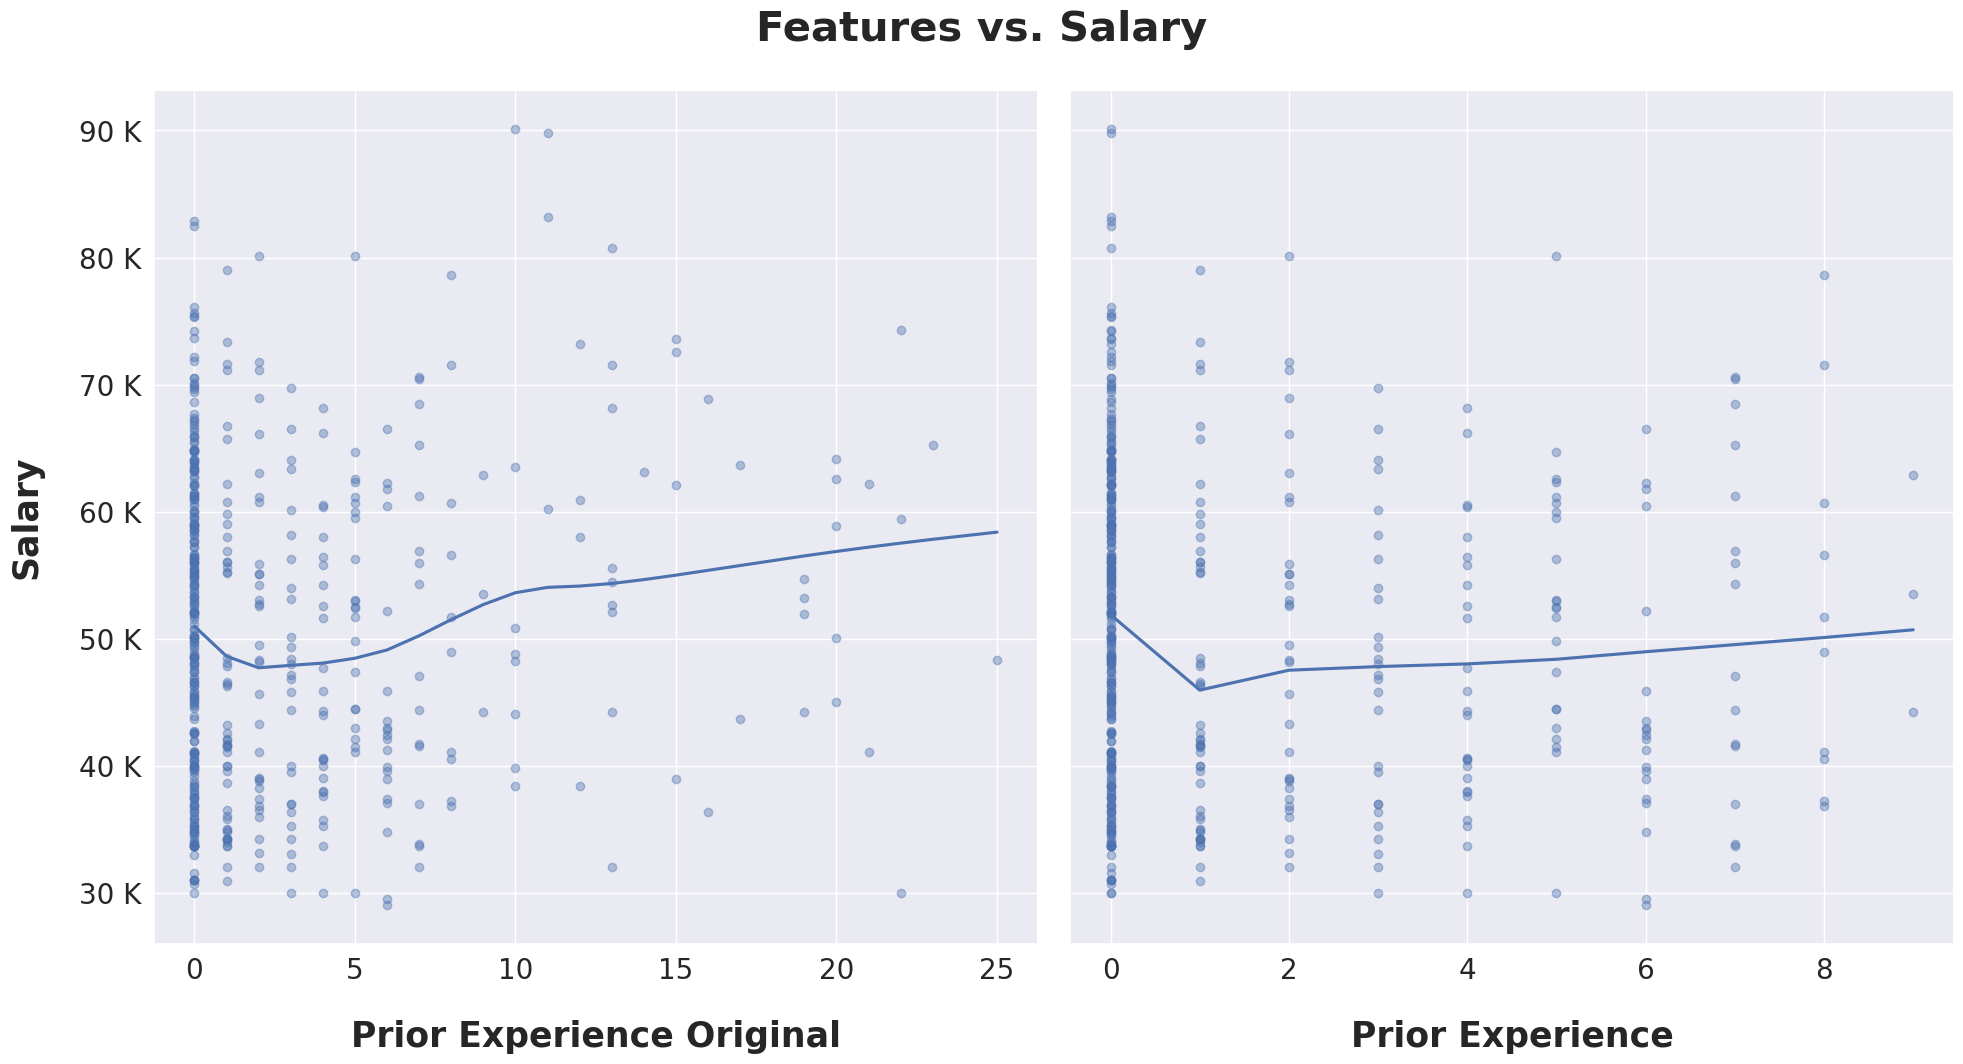

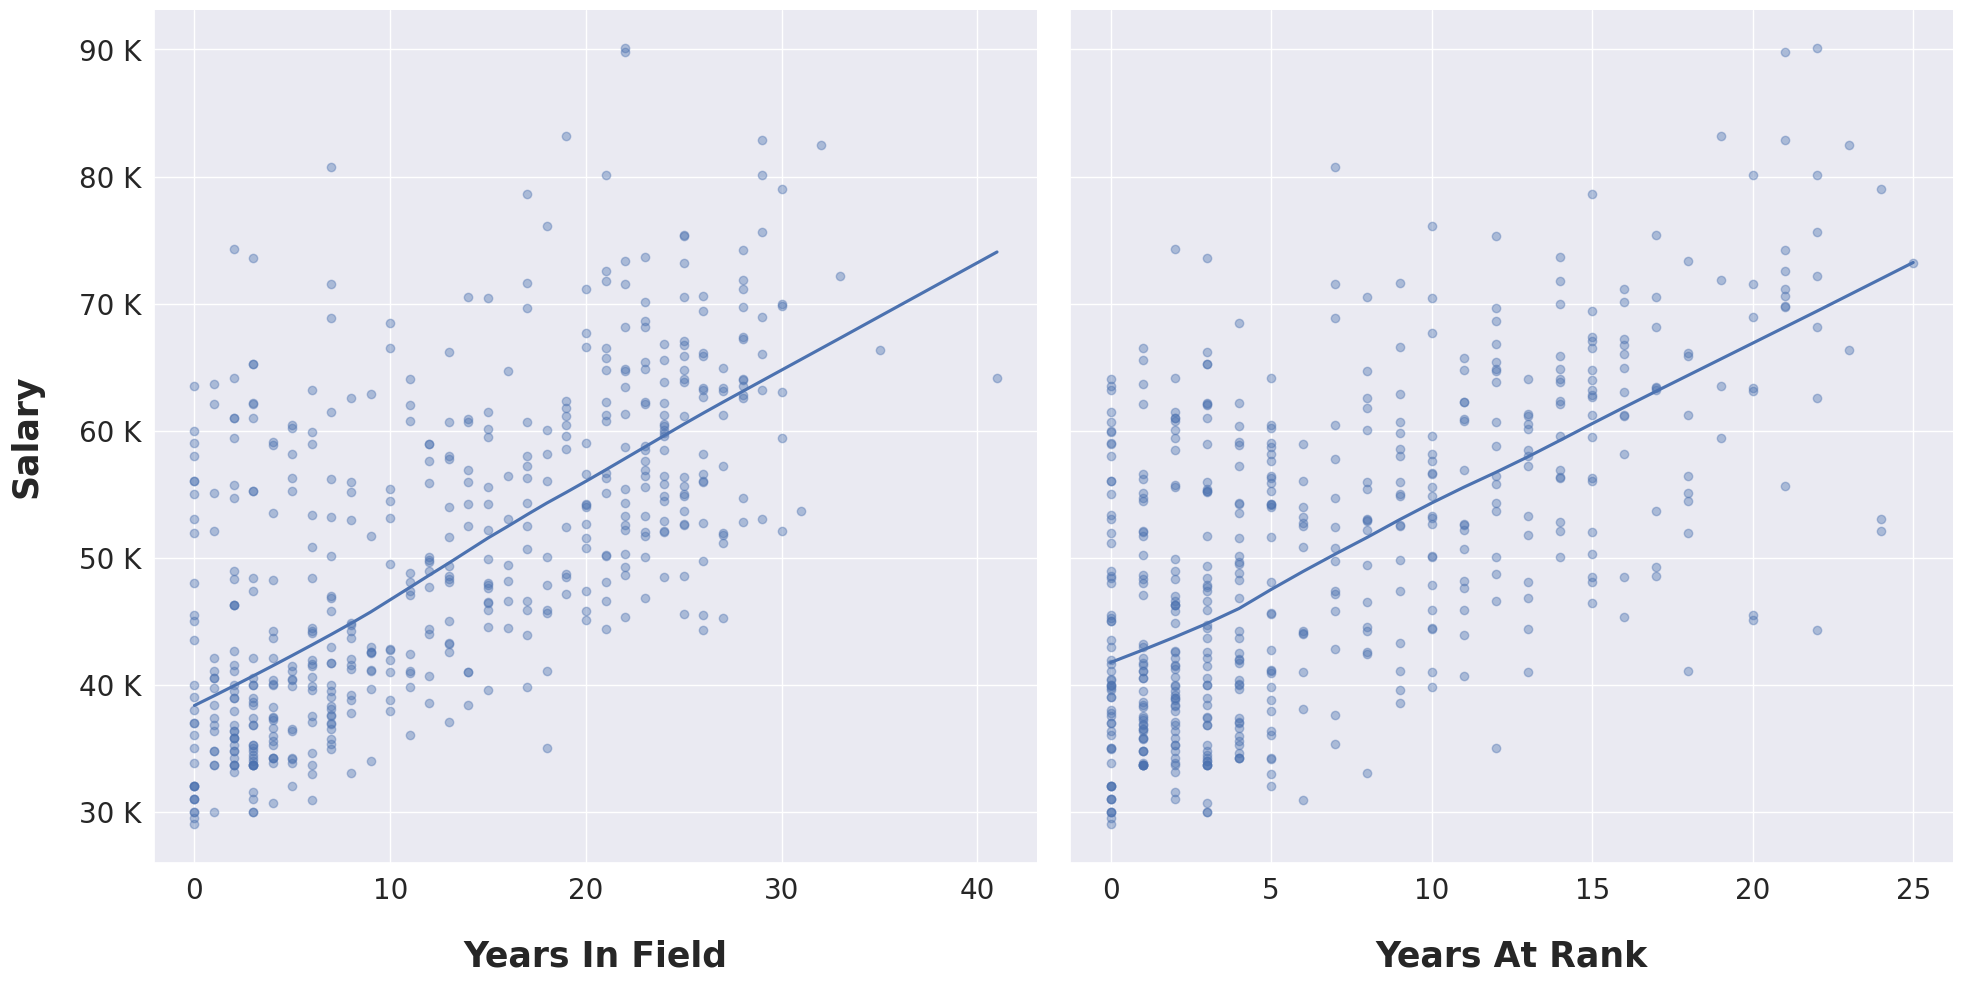

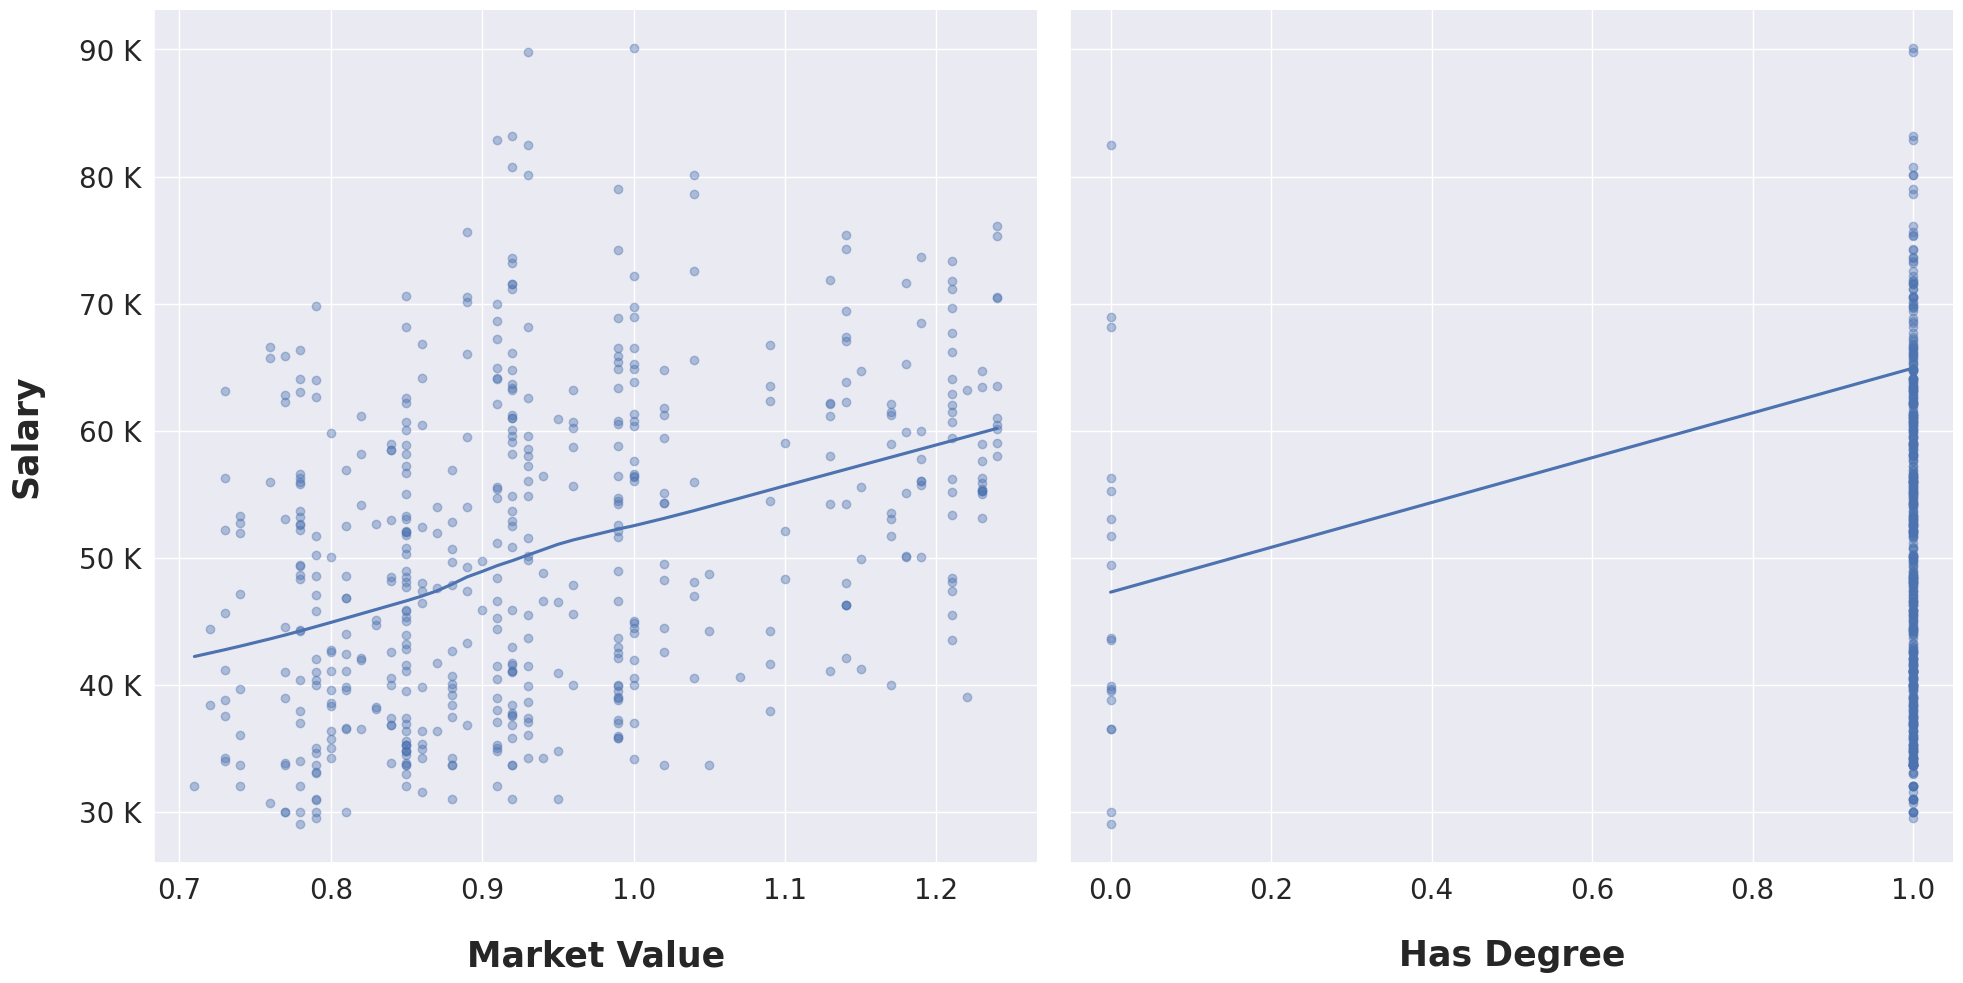

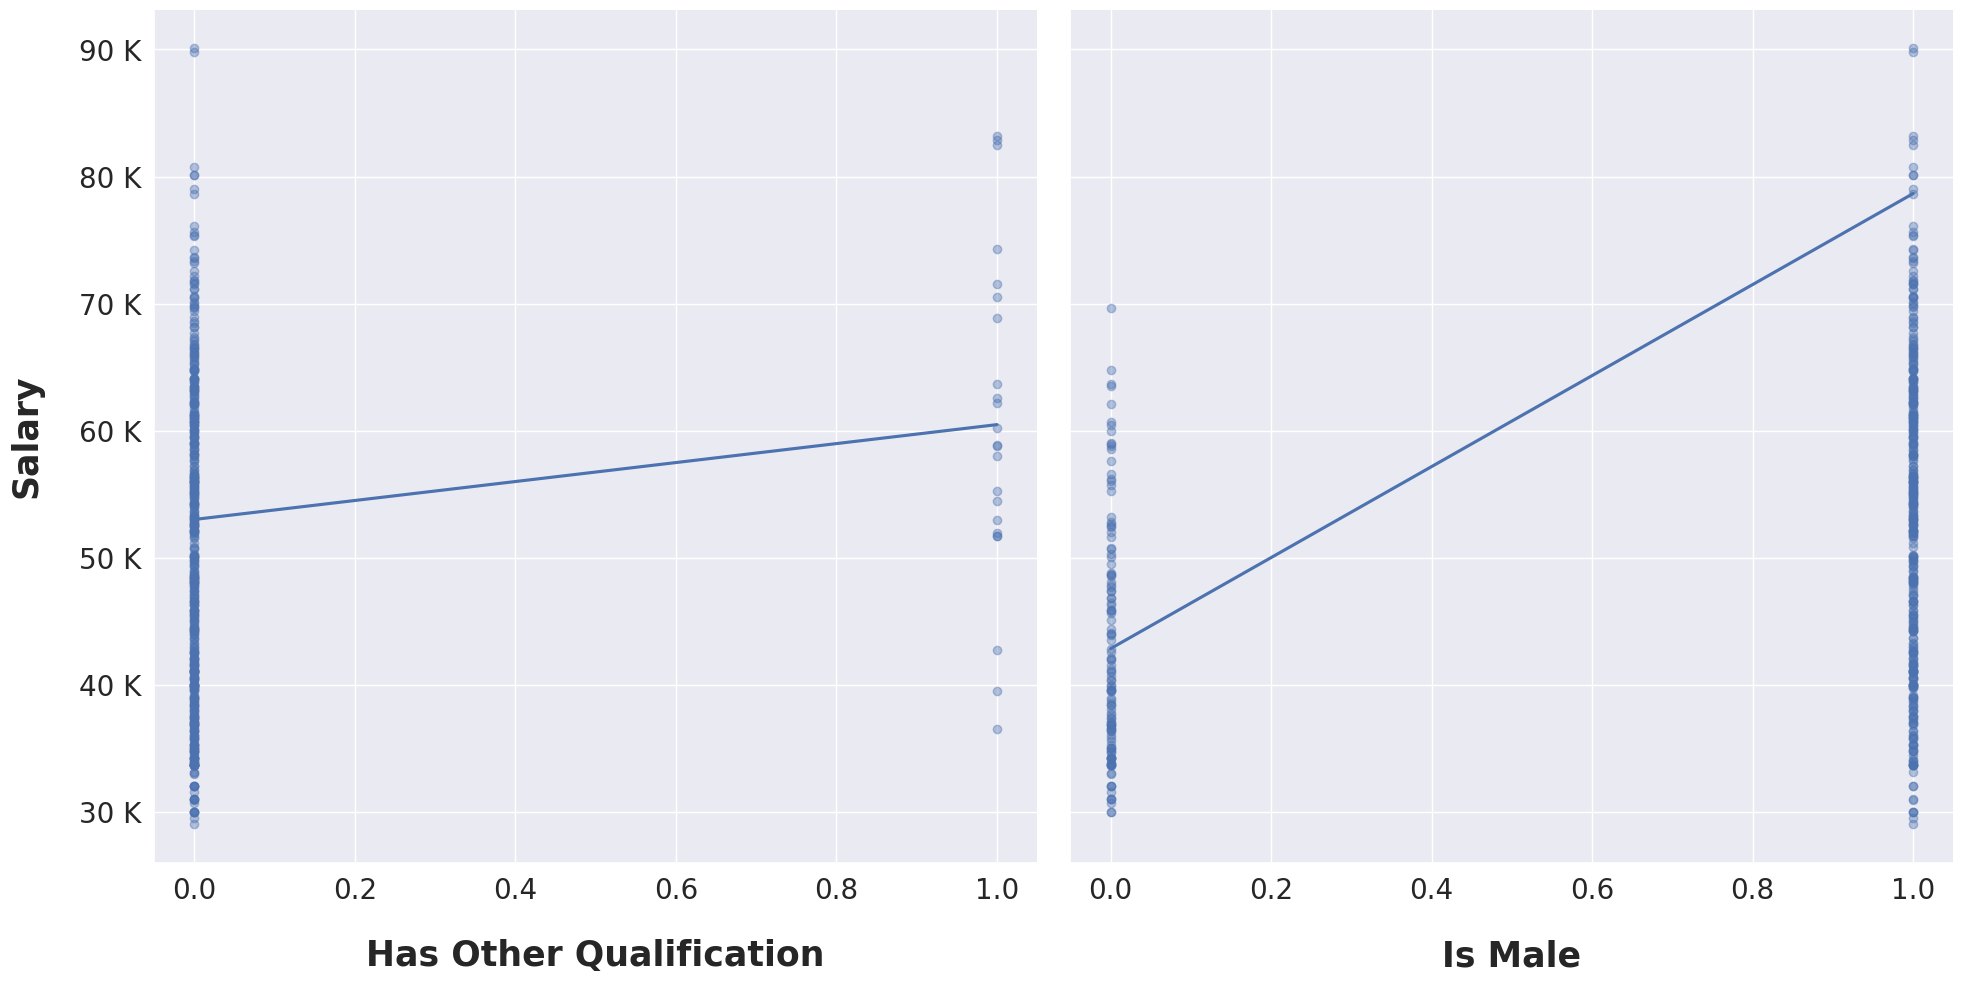

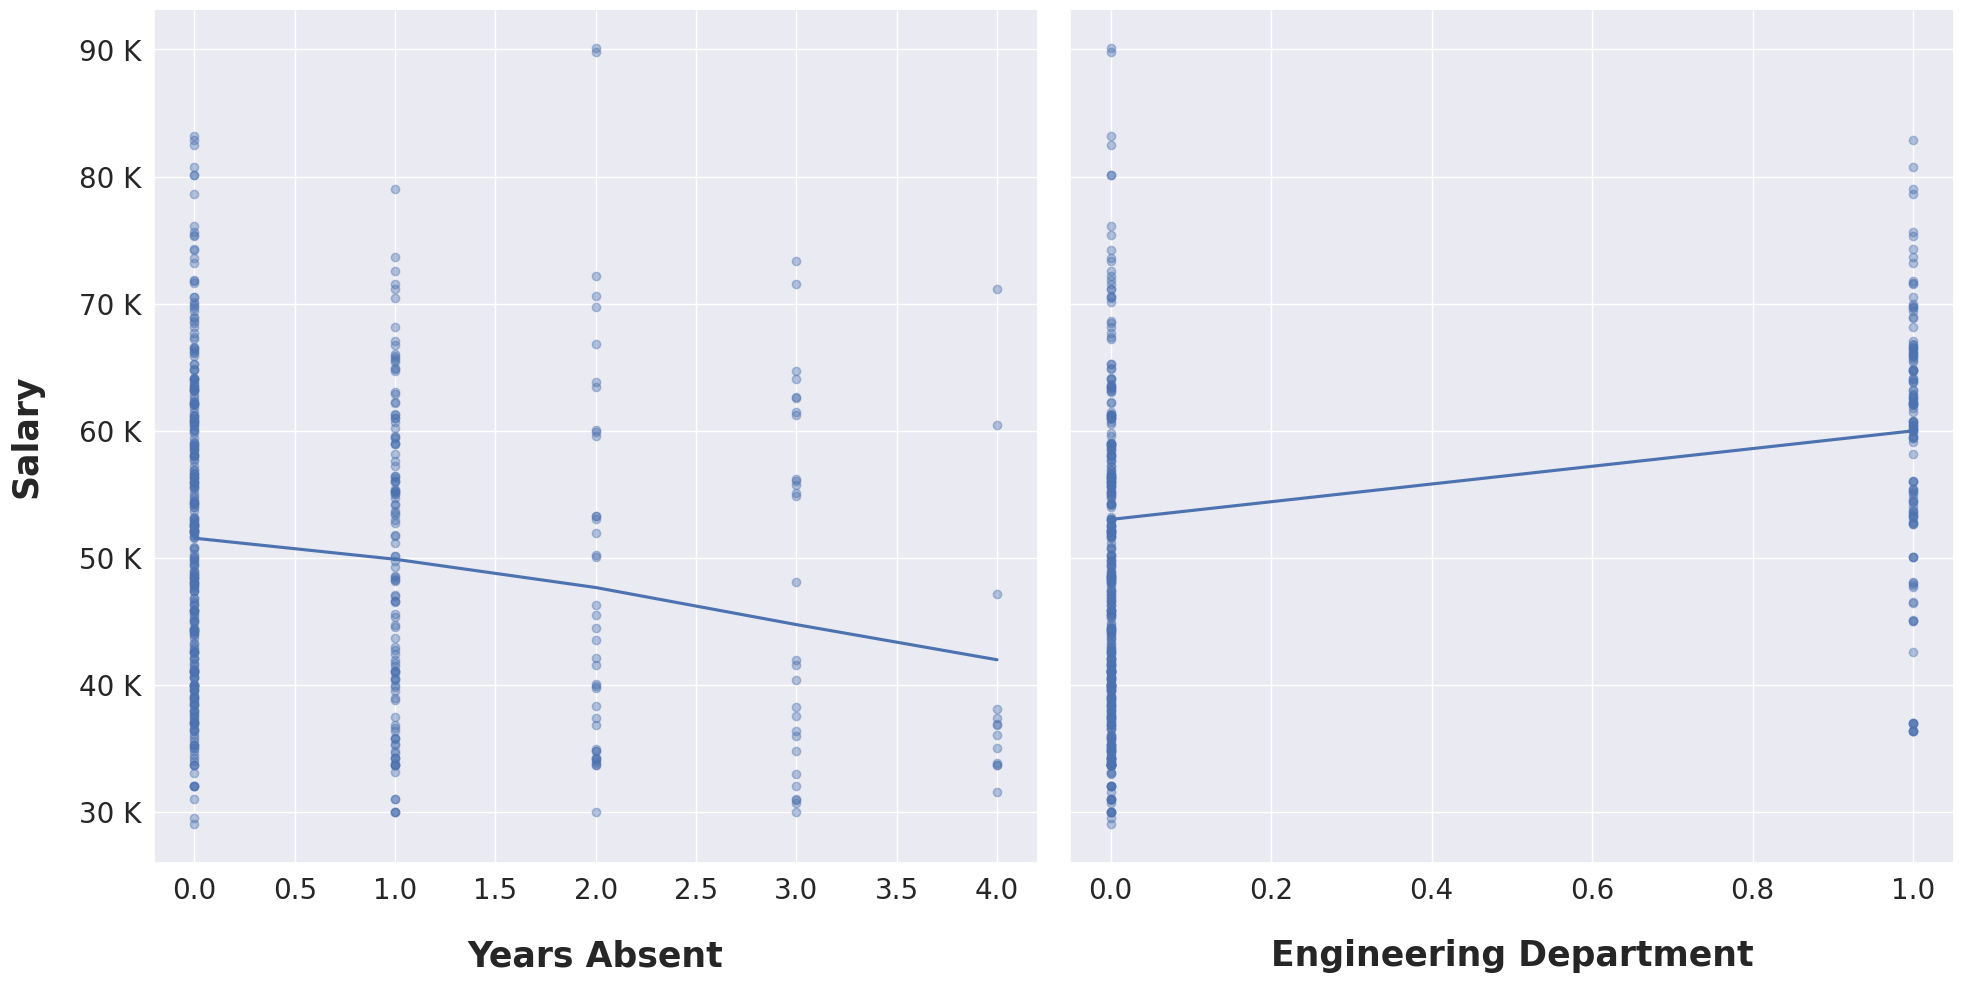

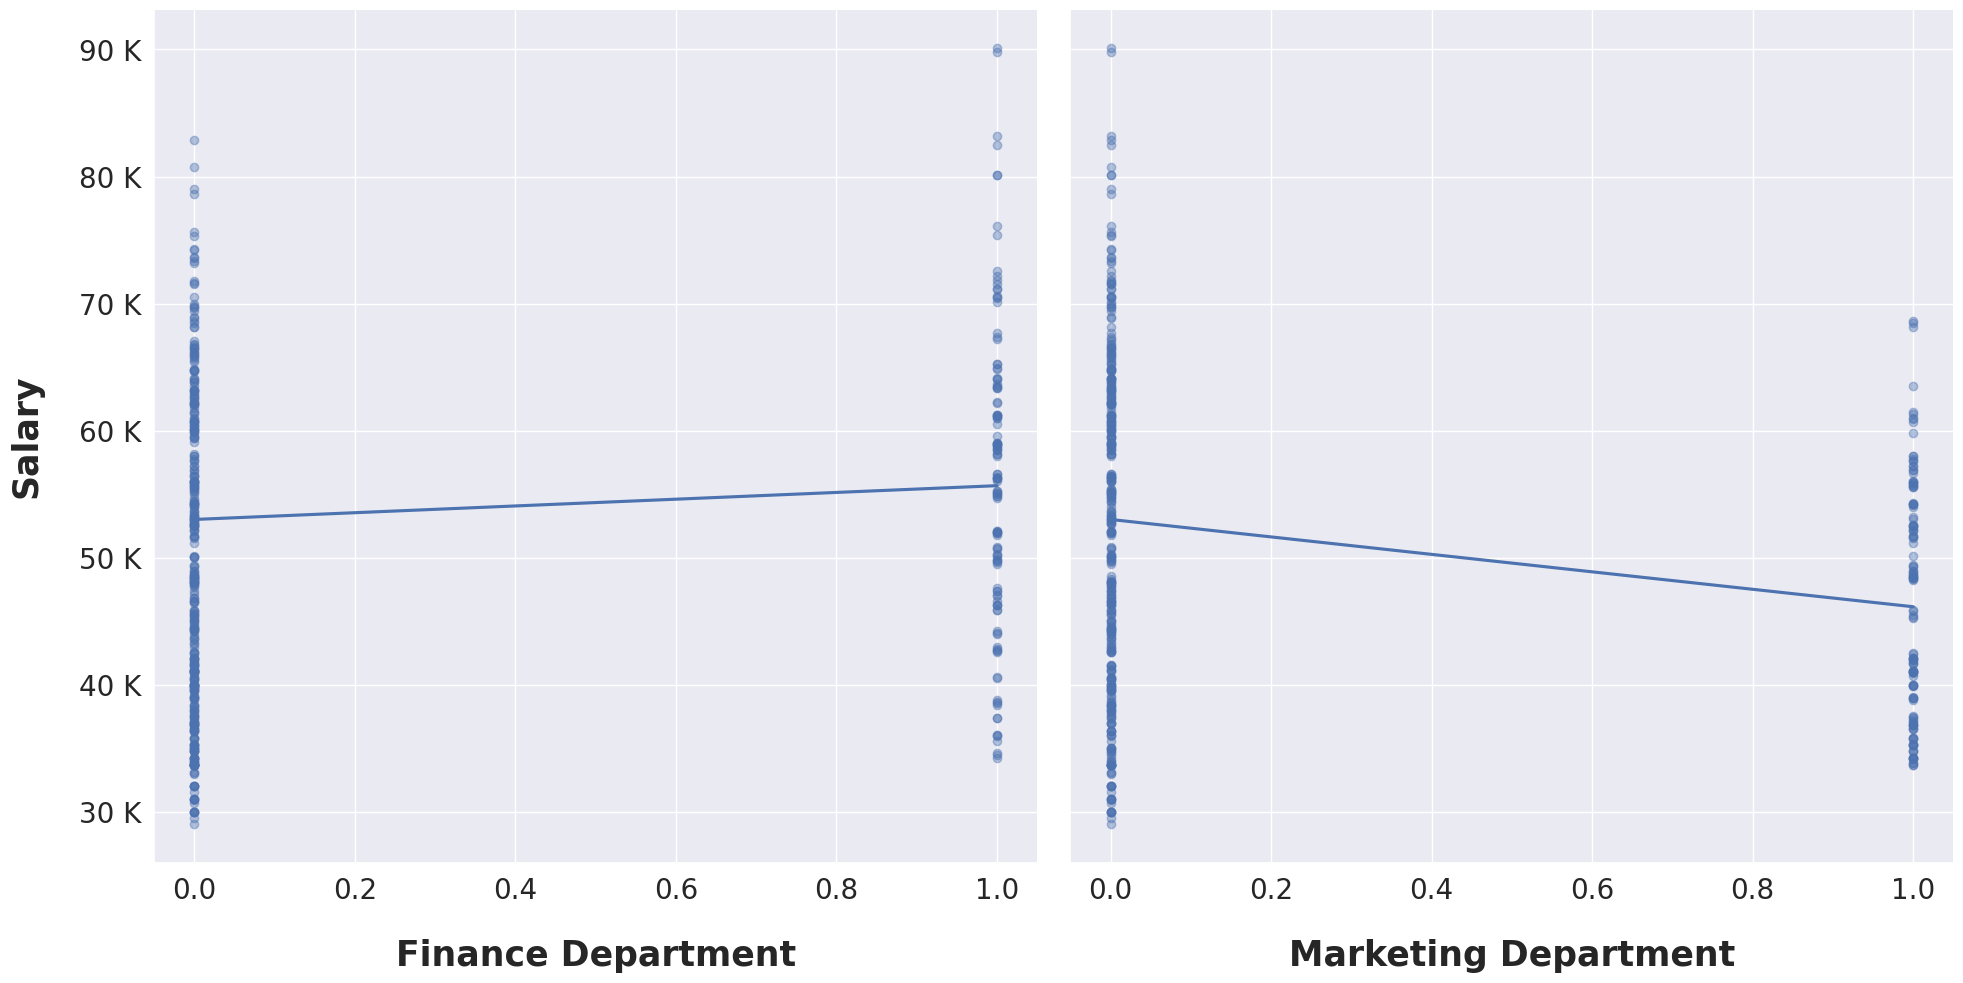

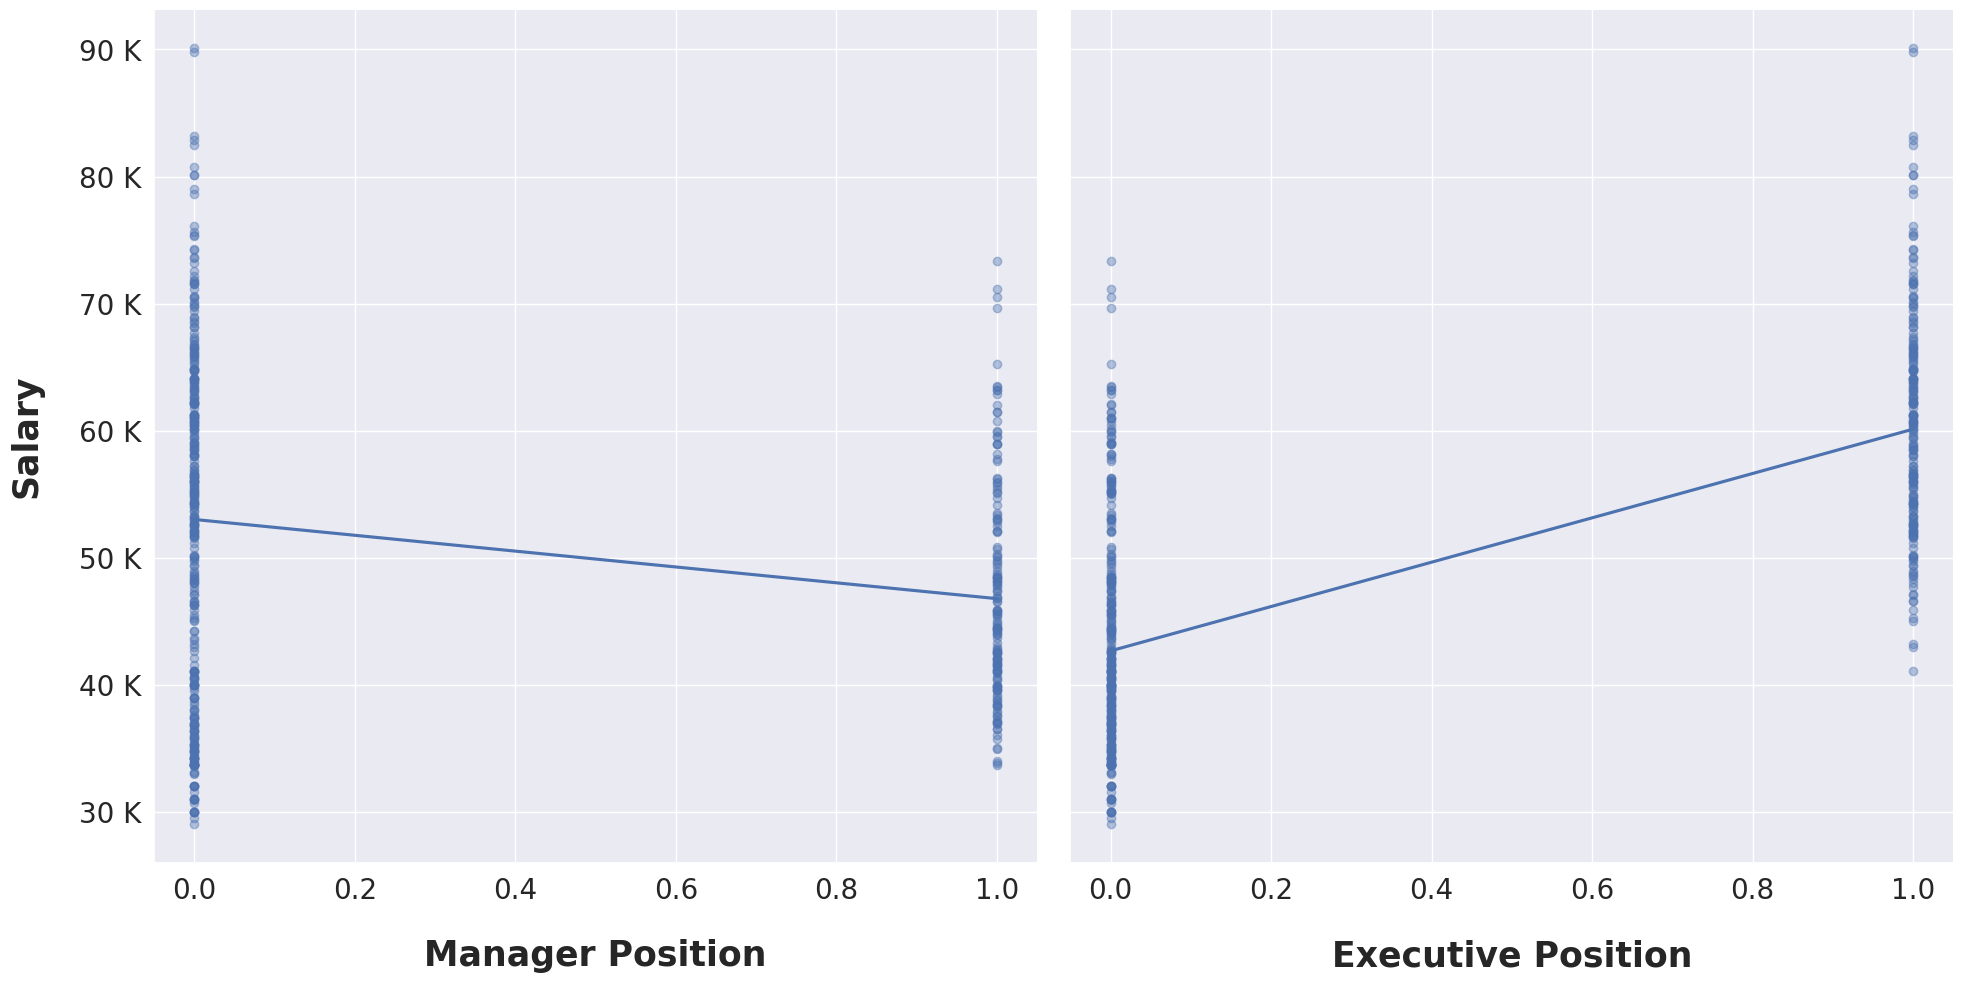

In [41]:
top_graph = create_pairplot(df, x_vars[:2])
top_graph.fig.suptitle("Features vs. Salary", y=1.0625)

create_pairplot(df, x_vars[2:4])
create_pairplot(df, x_vars[4:6])
create_pairplot(df, x_vars[6:8])
create_pairplot(df, x_vars[8:10])
create_pairplot(df, x_vars[10:12])
create_pairplot(df, x_vars[12:14])

plt.show()


<br />

<h4 align="center">Observations of Regressional Relations</h4>

<br />

<ul>
    <li>The majority of the plots show a nearly linear regression</li>
    <br />
    <li>An exception to the above are <b><i>Prior Experience</i></b> and <b><i>Prior Experience Original</i></b>
        <ul>
            <li>Both show a dip to year one of prior experience; almost as though employees are willing to take a pay cut in order to move on to a different position/company</li>
            <li>Minor increase after the first year</li>
            <li>Prior Experience Original looks to take about six years to return to the intercept value</li>
            <li>Regarding Prior Experience Original, from year 10 to year 25, there looks to be a minor total increase of roughly five thousand, showing a weak correlation</li>
            <li>Overall Prior Experience Original shows a 10 thousand Dollar increase in 25 years</li>
        </ul>
    </li>
    <br />
    <li>The following look to have strong positive correlational relationships with <b><i>Salary</i></b>:
        <ul>
            <li>Years in Field</li>
            <li>Years at Rank</li>
            <li>Market Value</li>
            <li>Executive Position</li>
        </ul>
    </li>
    <br />
    <li>Likewise, moderate correlations appear in these features:
        <ul>
            <li>Has Other Qualification</li>
            <li>Engineering Department</li>
            <li>Finance Department</li>
            <li>Marketing Department</li>
            <li>Is Male</li>
        </ul>
    </li>
    <br />
    <li>The above features look as though they are likely to have the greatest effect</li>
</ul>

<br />
<br />


<h4 align="center">R<sup>2</sup> Correlational Heatmap</h4>

<br />

<ul>
    <li>In the following, we will make use of R<sup>2</sup> in order to compare correlations scores across the map. The reasoning behind this is that it makes it easy to guage the weight of each result as shown in the metrics list below</li>
    <br />
    <li>Metrics for R<sup>2</sup> as explained by <b><i>Cohen (1988)</i></b>:
        <ul>
            <li>0.01 &lt; r<sup>2</sup> &lt; 0.09: Weak Effect</li>
            <li>0.09 &lt; r<sup>2</sup> &lt; 0.25: Moderate Effect</li>
            <li>r<sup>2</sup> &gt; 0.25: Strong Effect</li>
        </ul>
    </li>
    <br />
    <li><b><i>Note:</i></b> By default, <i>pandas'</i> correlation algorithm uses a <b><i>Pearson</i></b> model</li>
</ul>

<br />
<br />


In [73]:
color_map = "YlGnBu"

correlations = df.corr().apply(lambda x: x*x)

mask = np.triu(correlations)
np.fill_diagonal(a=mask, val=False)

correlation_heatmap = sns.heatmap(
    data=round(correlations, 2),
    cmap=color_map,
    annot=True,
    mask=mask,
)

correlation_heatmap.set_title("Feature Set Correlational Heatmap")
correlation_heatmap.set_ylabel("$R^2$ Correlation")
correlation_heatmap.set_xlabel("$R^2$ Correlation")

tick_labels = [
    word.replace("_", " ").title()
    for word in df.columns
]

correlation_heatmap.set_yticklabels(tick_labels)
correlation_heatmap.set_xticklabels(tick_labels)

plt.plot()


[]

<br />

<h4 align="center">Observations of General Correlations</h4>

<br />

<ul>
    <li><b><i>Years in Field</i></b> and <b><i>Years at Rank</i></b> are highly correlated, with <b><i>Years in Field</i></b> having more correlation to <b><i>Salary</i></b>, it looks to be the better candidate</li>
    <br />
    <li>Likewise, <b><i>Executive Position</i></b>, <b><i>Years in Field</i></b> and <b><i>Manger Position</i></b> show correlation; perhaps dropping <b><i>Executive Position</i></b> may solve this issue as it <i>'kills two birds with one stone'</i></li>
</ul>

<br />
<br />


<h4 align="center">Salary vs. Feature Set</h4>
<h5 align="center">R<sup>2</sup> Correlational Heatmap</h5>

<br />

<p>The following just allows us to better focus on how the target is related to the feature set.</p>

<br />
<br />


In [72]:
salary = "salary"

salary_correlation_r = pd.DataFrame(
    df.corr()[salary],
    index=x_vars
)

salary_correlation_rsquared = salary_correlation_r.apply(
    lambda x: x*x
)

salary_correlation_rsquared = salary_correlation_rsquared.sort_values(
    salary,
    ascending=False
)


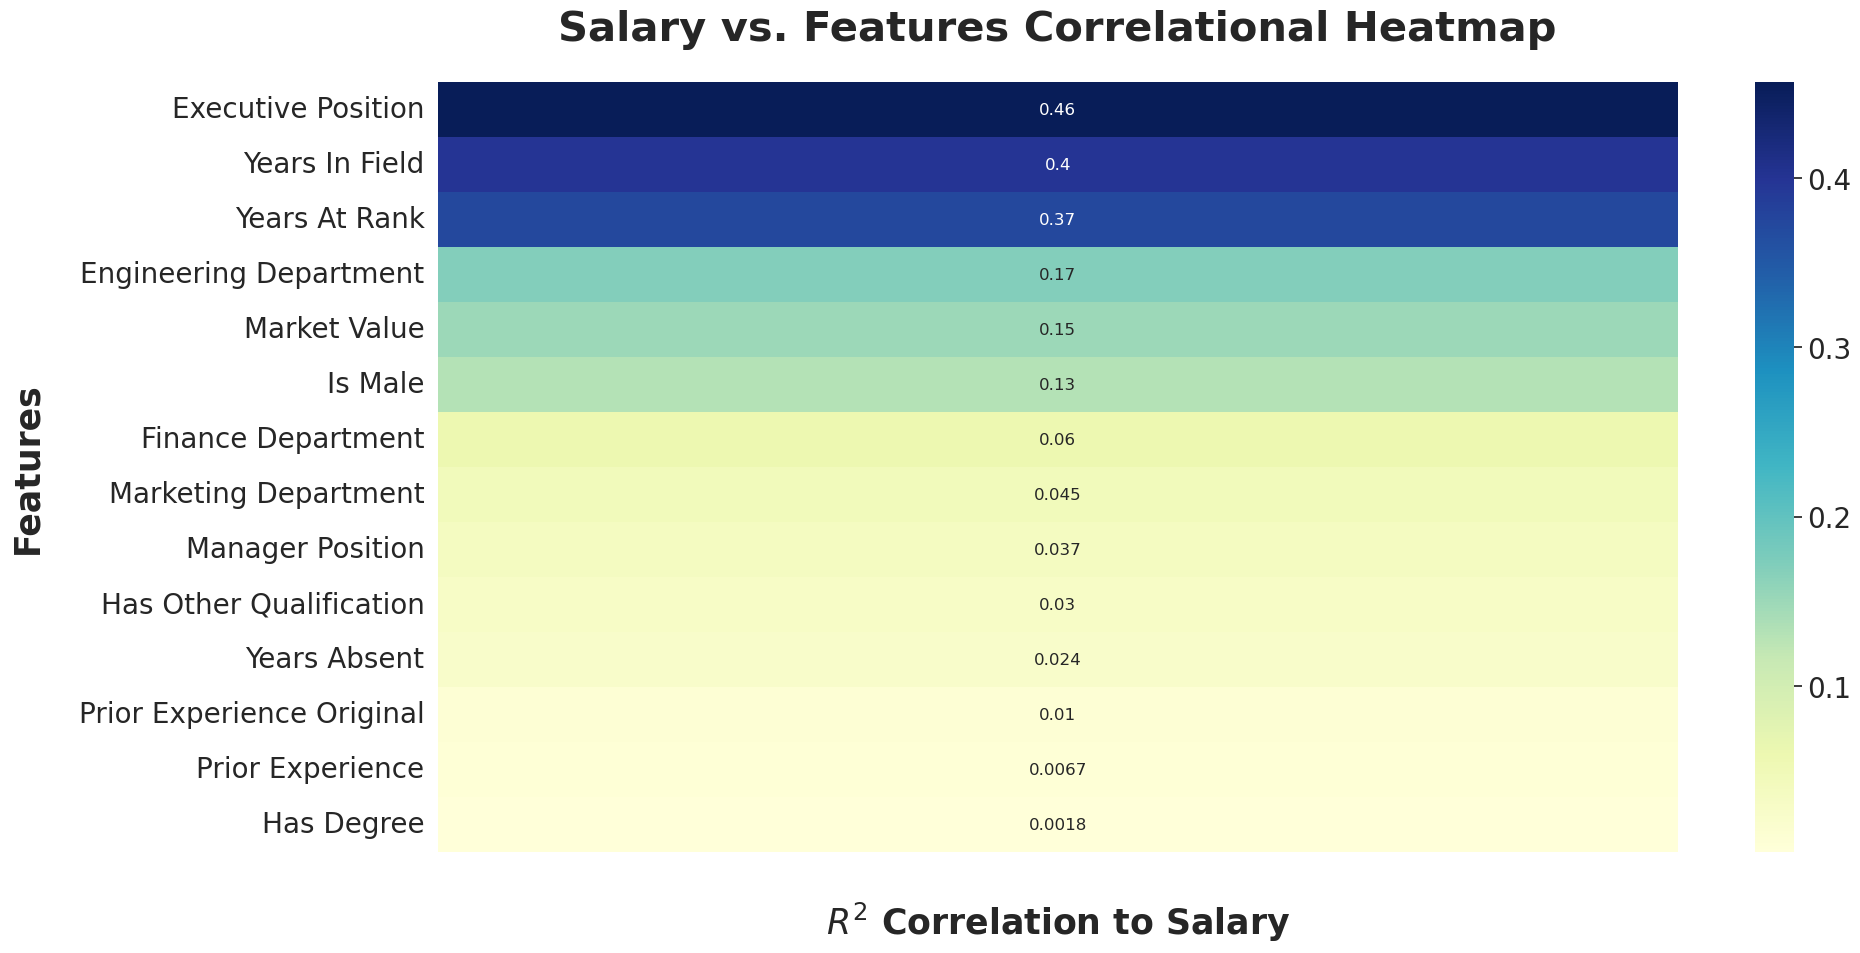

In [71]:
salary_correlation_heatmap = sns.heatmap(
    data=salary_correlation_rsquared,
    cmap=color_map,
    annot=True
)

salary_correlation_heatmap.set_title("Salary vs. Features Correlational Heatmap")
salary_correlation_heatmap.set_xlabel("$R^2$ Correlation to Salary")
salary_correlation_heatmap.set_ylabel("Features")

y_tick_labels = [
    word.replace("_", " ").title()
    for word in salary_correlation_rsquared.index
]

salary_correlation_heatmap.set_yticklabels(y_tick_labels)
salary_correlation_heatmap.set_xticklabels([])

plt.show()


<br />

<h4 align="center">Observations of Correlational Relations</h4>

<br />

<ul>
    <li>The following cause strong effect:
        <ul>
            <li>Executive Position: r<sup>2</sup> = 0.46</li>
            <li>Years in Field: r<sup>2</sup> = 0.4</li>
            <li>Years at Rank: r<sup>2</sup> = 0.38</li>
        </ul>
    </li>
    <br />
    <li>Moderate effect from the follwing:
        <ul>
            <li>Engineering Department: r<sup>2</sup> = 0.17</li>
            <li>Market Value: r<sup>2</sup> = 0.16</li>
            <li>Is Male: r<sup>2</sup> = 0.13</li>
        </ul>
    </li>
    <br />
    <li>All other features off little correlational value</li>
    <br />
    <li>Both the strongly and moderately effective features are viable for feature selection</li>
</ul>

<br />
<br />


<h2 align="center">Normalization</h2>

<br />
<br />


<h3 align="center">Range</h3>

<br />

<p>As mentioned before, owing to the wide range of values in <b><i>Salary</i></b>, it only seems reasonable to scale its values.</p>

<br />
<br />


In [45]:
pd.DataFrame(
    data={
    "Minimum": df[salary].min(),
    "Maximum": df[salary].max(),
    "Range": df[salary].max() - df[salary].min(),
    },
    index=["Values"]
)


,Minimum,Maximum,Range
Values,29000.0,90082.0,61082.0


<br />

<h3 align="center">Distribution</h3>

<br />

<ul>
    <li>As to whether or not it wise to also scale any other feature, it looks as though features that related to <b><i>skew</i></b> are likely to offer the best insight.</li>
    <br />
    <li>Note however that <i>binary</i> categories fall out of this consideration as they alikely to have quasi-bimodal peaks, inclusive are:</li>
    <ul>
        <li>Qualifications</li>
        <li>Gender</li>
        <li>Work Deparments</li>
        <li>Employee Positions</li>
    </ul>
    <br />
    <li><b><i>Market Value</i></b> looks to have already been log transformed</li>
</ul>

<br />
<br />


In [46]:
def distribution_grid(df, title):
    num_employees = "Number of Employees"
    fig, ax = plt.subplots(3, 2, figsize=(LARGE, SMALL*2))

    sns.histplot(
        df[salary], ax=ax[0][0], kde=True
    ).set(ylabel=num_employees, xlabel="Salary")

    sns.histplot(
        df[x_vars[0]], ax=ax[0][1], kde=True
    ).set(ylabel=None, xlabel="Prior Experience Original")

    sns.histplot(
        df[x_vars[1]], ax=ax[1][0], kde=True
    ).set(ylabel=num_employees, xlabel="Prior Experience")

    sns.histplot(
        df[x_vars[4]], ax=ax[1][1], kde=True
    ).set(ylabel=None, xlabel="Market Value")

    sns.histplot(
        df[x_vars[2]], ax=ax[2][0], kde=True
    ).set(ylabel=num_employees, xlabel="Years in Field")

    sns.histplot(
        df[x_vars[3]], ax=ax[2][1], kde=True
    ).set(ylabel=num_employees, xlabel="Years at Rank")

    plt.suptitle(title, y=1.025)

    fig.tight_layout(h_pad=2, w_pad=2)

    plt.show()


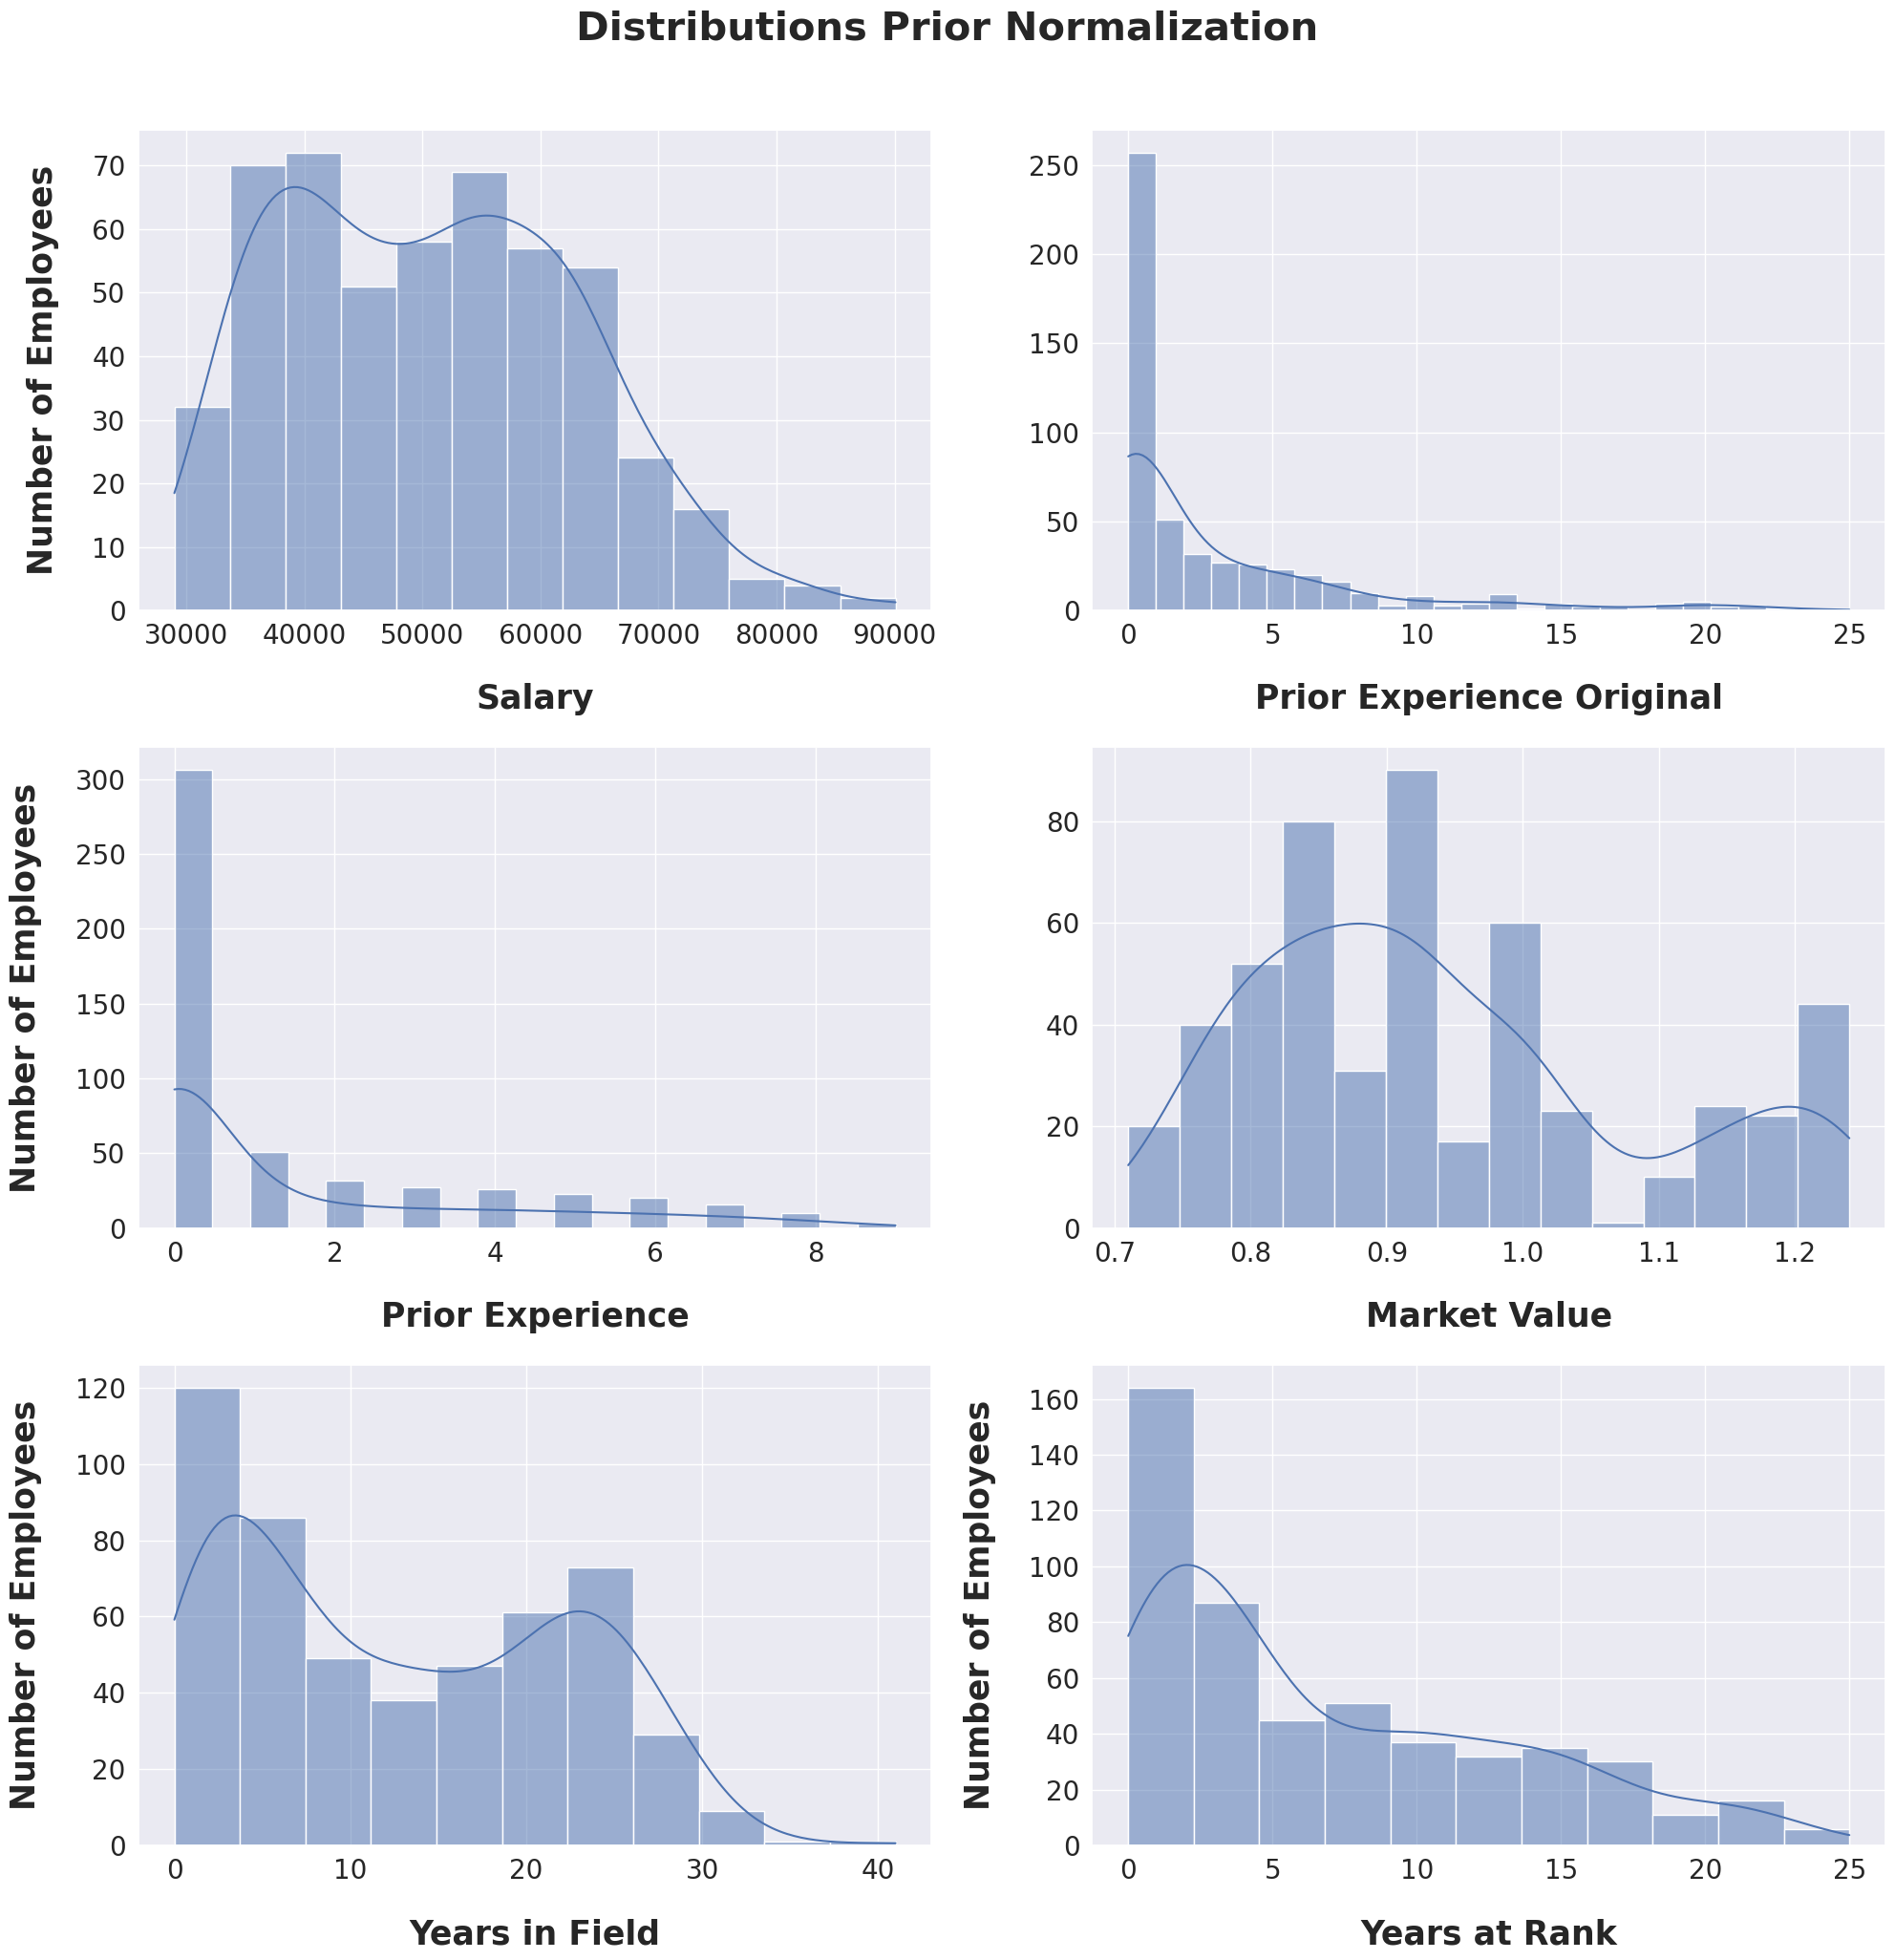

In [47]:
distribution_grid(df, "Distributions Prior Normalization")


<br />

<h3 align="center">Transformation</h3>

<br />
<br />


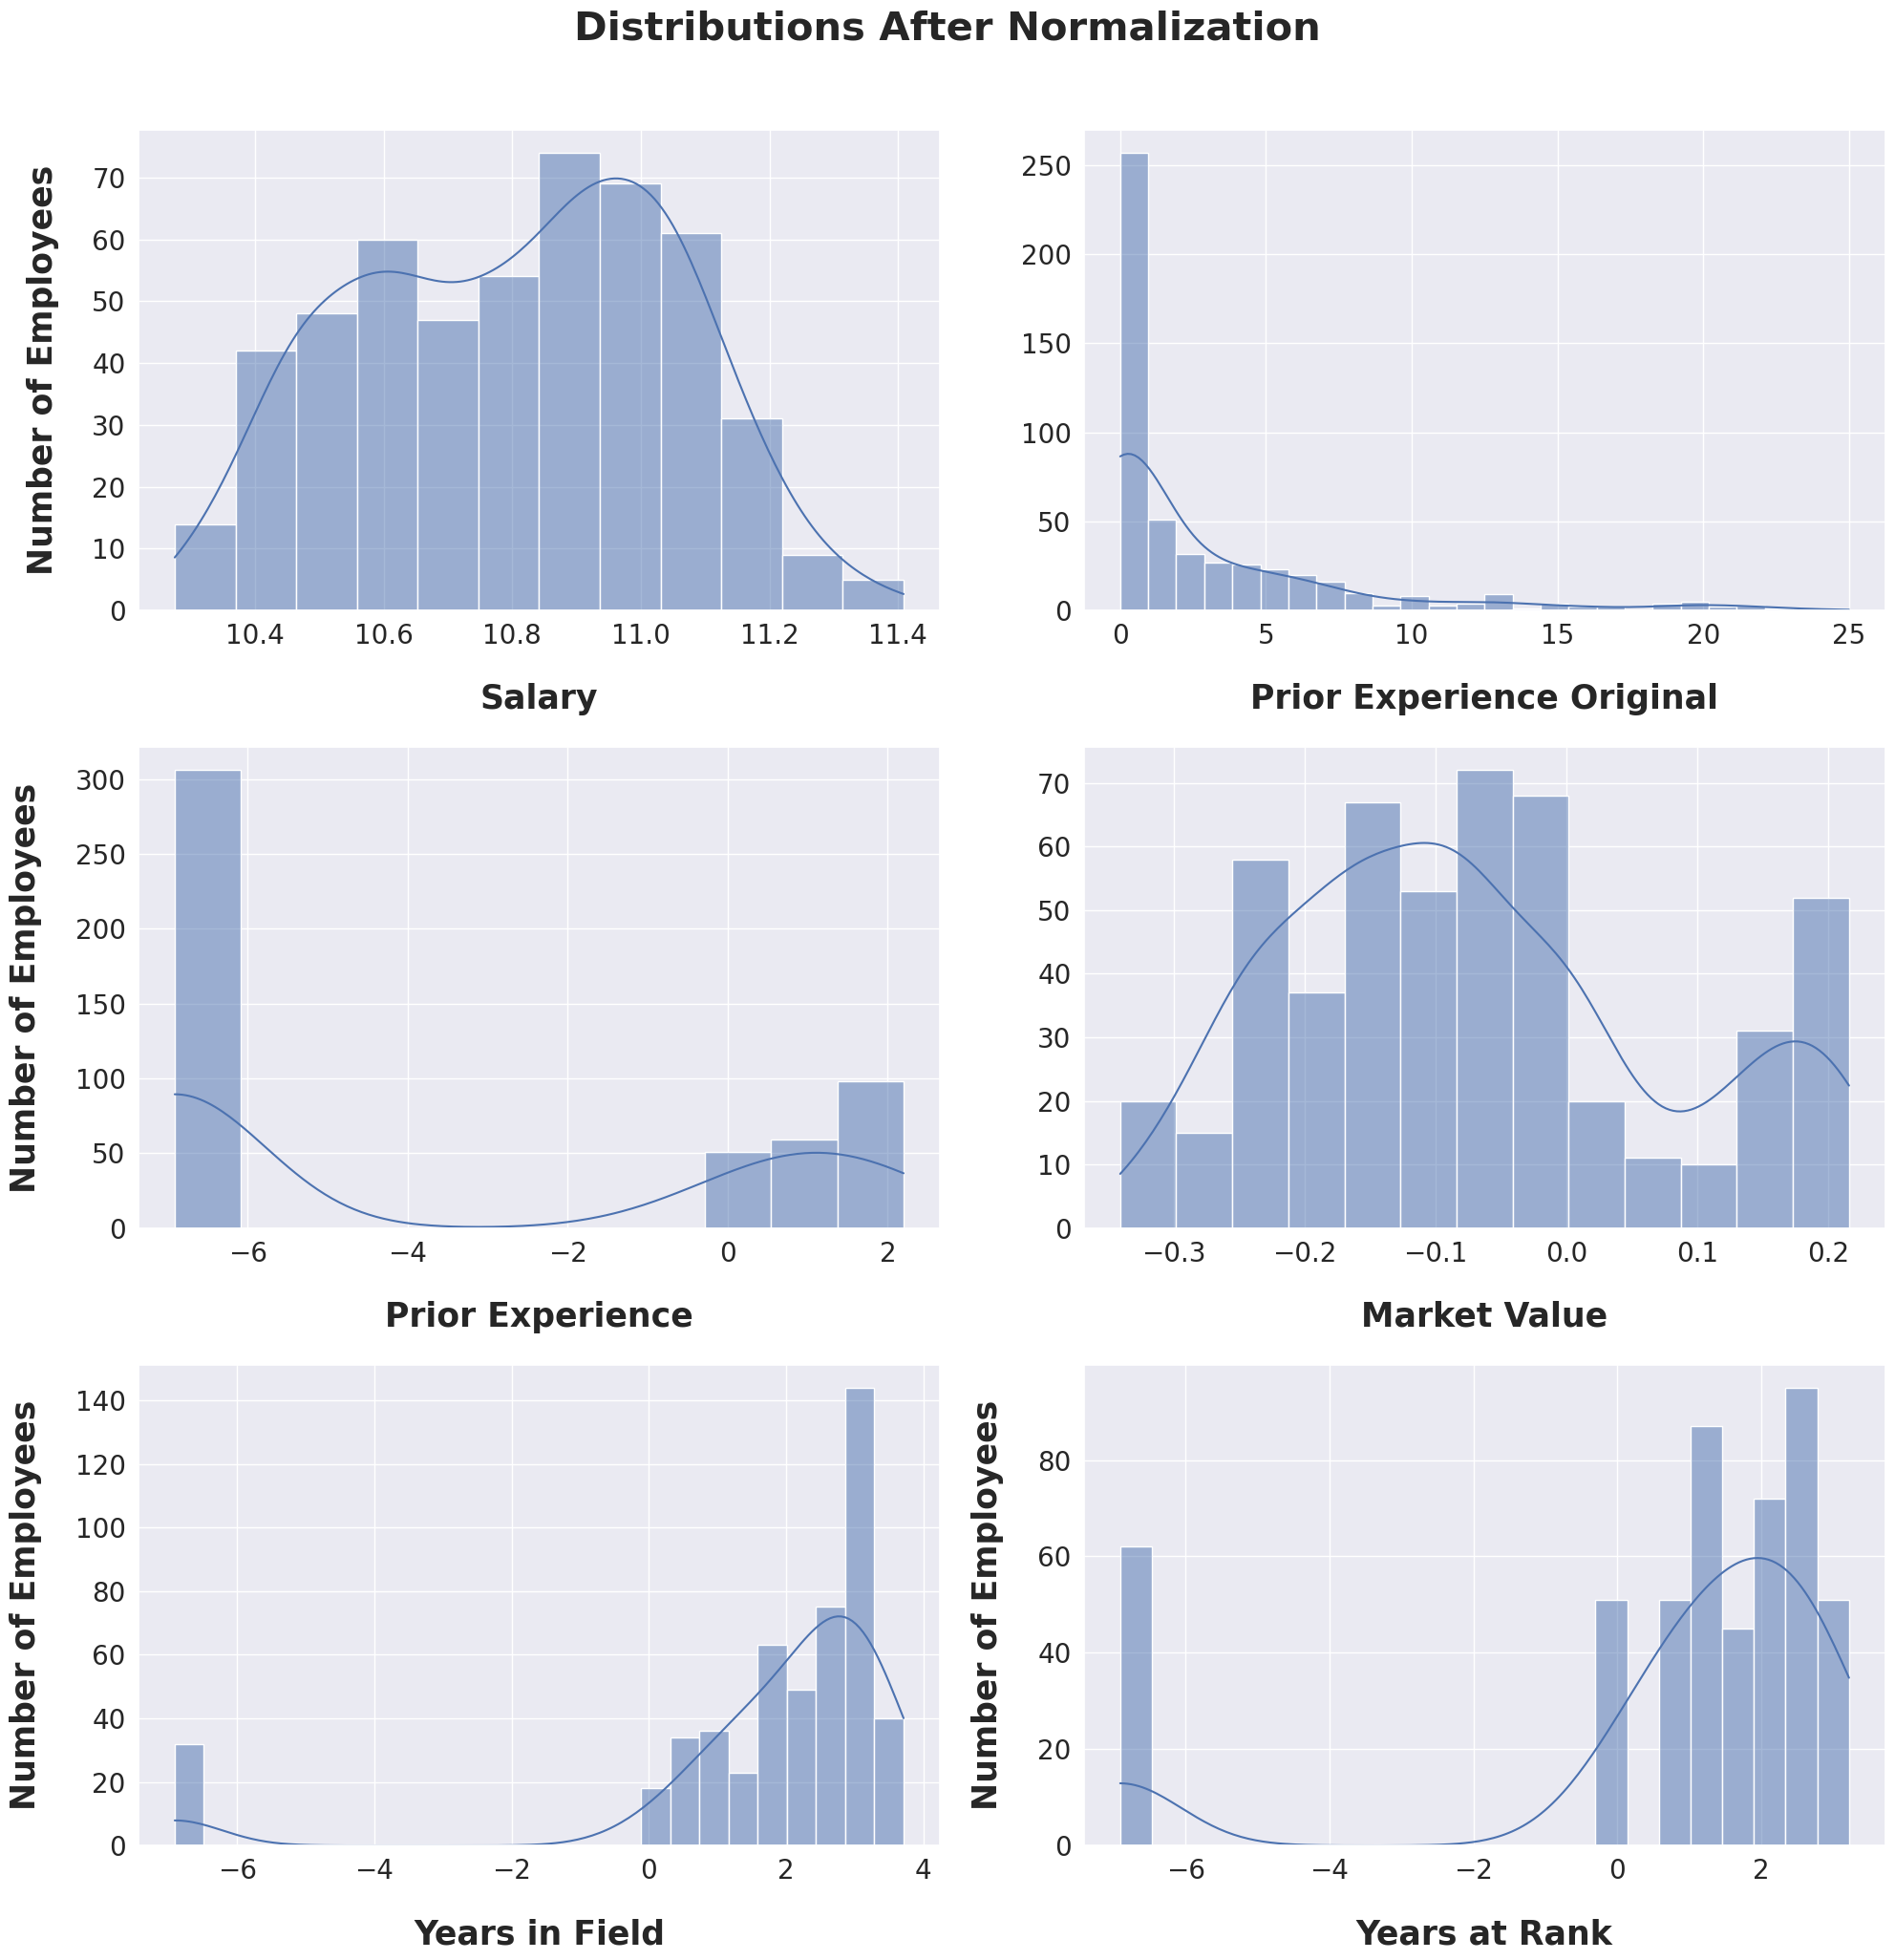

In [48]:
df[discrete_features] = df[discrete_features].add(0.001).apply(np.log)
distribution_grid(df, "Distributions After Normalization")


<br />

<h4 align="center">Observation of Transformation</h4>

<br />

<p>The scales have been standardized; though it is wise to recall that the skew nature of some of the features has not been a 100% solved.</p>

<p>Worse yet, <b><i>Prior Experience Original</i></b> has seen virtually no change in distribution.</p>

<br />
<br />


<h2 align="center">Feature Selection</h2>

<br />

<p>In search of the optimal feature set, combinations of the following collinear feature will be pitted against each other:
    <ul>
        <li>Years in Field</li>
        <li>Years at Rank</li>
        <li>Executive Position</li>
    </ul>
</p>

<p>Although <b><i>Manager Position</i></b> and <b><i>Executive Position</i></b> are collinear, <b><i>Manager Position</i></b> offers little relation to <b><i>Salary</i></b>.</p>

<p><b>Note:</b> The model comparison will be with the use of the <a href="https://en.wikipedia.org/wiki/Bayesian_information_criterion">Bayesian Information Criterion (BIC)</a>, wherein the smaller value is preferred. The reasoning behind this is that <i>BIC</i> offers an unbiased model prediction even though we are currently comparing collinearity.</p>

<br />
<br />


<h3 align="center">Hypothesis</h3>

<br />

<ul>
    <li><b><i>H<sub>0</sub></i></b>: There is no difference in the BIC values between the combinations of collinear features</li>
    <br />
    <li><b><i>H<sub>1</sub></i></b>: One of the combinations of collinear features has the lowest BIC value</li>
    <br />
    <li><b><i>&alpha; = 0.01</i></b>; this ensures a generally strict standard.</li>
</ul>

<br />
<br />


<h4 align="center">Exploratory Feature Sets</h4>

<br />
<br />


In [49]:
feature_set_1 = ["years_in_field", "executive_position"]
feature_set_2 = ["years_at_rank", "executive_position"]

moderate_correlation = ["market_value", "is_male", "engineering_department"]


<br />

<h4 align="center">Exploratory Models</h4>

<br />
<br />


In [50]:
def create_model(df, features):
    X = df[features]
    y = df[salary]

    return sm.OLS(y, X).fit()


In [51]:
exploratory_model_1 = create_model(
    df,
    feature_set_1 + moderate_correlation
)

exploratory_model_2 = create_model(
    df,
    feature_set_2 + moderate_correlation
)


<br />

<h4 align="center">Exploratory Model Comparison</h4>

<br />
<br />


In [52]:
bic_map = {
    "Exploratory Model 1": exploratory_model_1.bic,
    "Exploratory Model 2": exploratory_model_2.bic,
}

f_pvalue_map = {
    "Exploratory Model 1": exploratory_model_1.f_pvalue,
    "Exploratory Model 2": exploratory_model_2.f_pvalue,
}

rsquare_adjusted_map = {
    "Exploratory Model 1": exploratory_model_1.rsquared_adj,
    "Exploratory Model 2": exploratory_model_2.rsquared_adj,
}

pd.DataFrame(
    [bic_map, f_pvalue_map, rsquare_adjusted_map],
    index=["BIC Values", "F p-values", "Adjusted R-Square"]
)


,Exploratory Model 1,Exploratory Model 2
BIC Values,3.101663e+03,3.103495e+03
F p-values,6.216931e-177,1.538699e-176
Adjusted R-Square,8.010538e-01,8.003431e-01


<br />

<h4 align="center">Hypothesis Results</h4>

<br />

<ul>
    <li>We reject the Null-Hypothesis owing to the low <b><i>F p-value</i></b>, well below &alpha; = 0.01</li>
    <br />
    <li>Further more, model 1 has a minutely lower <i>BIC</i> value:
        <ul>
            <li>BIC<sub>exploratory model 1</sub> = 3 101.7</li>
            <li>BIC<sub>exploratory model 2</sub> = 3 103.5</li>
        </ul>
    </li>
    <br />
    <li>Likewise, the Adjusted R<sup>2</sup> is slightly higher for model 1:
        <ul>
            <li>Adjusted R<sup>2</sup><sub>exploratory model 1</sub> = 0.8105</li>
            <li>Adjusted R<sup>2</sup><sub>exploratory model 2</sub> = 0.8003</li>
        </ul>
    </li>
    <br />
    <li><b><i>Feature Set 1</i></b> has the lower <b><i>BIC</i></b> value and the <b><i>Adjusted R<sup>2</sup></i></b> value is only about 1%</li>
</ul>

<br />
<br />


<h2 align="center">Modeling</h2>

<h4 align="center">Feature Set 1</h4>

<h5 align="center">and</h5>

<h4 align="center">Moderately Relational Features</h4>

<br />
<br />


In [53]:
X = df[feature_set_1 + moderate_correlation]
y = df[salary]


In [54]:
split = train_test_split(X, y, train_size=0.2, random_state=20)

X_train, X_test, y_train, y_test = split
X_train = sm.add_constant(X_train)

final_model = sm.OLS(y_train, X_train).fit()


In [55]:
pd.DataFrame(
    data = final_model.pvalues <= 0.01,
    columns=["Statistically Significant"]
).T


,const,years_in_field,executive_position,market_value,is_male,engineering_department
Statistically Significant,True,True,True,True,False,False


<br />

<h4 align="center">p-value Observations</h4>

<br />

<ul>
    <li>As a reminder, &alpha; = 0.01</li>
    <br />
    <li><b><i>Is Male</i></b> does not meet the criteria and will be dropped</li>
</ul>

<br />
<br />


In [56]:
final_moderate_correlation = moderate_correlation.copy()
final_moderate_correlation.remove("is_male")
X = df[feature_set_1 + final_moderate_correlation]
y = df[salary]


In [57]:
split = train_test_split(X, y, train_size=0.2, random_state=2)

X_train, X_test, y_train, y_test = split

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

final_model = sm.OLS(y_train, X_train).fit()
final_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     66.44
Date:                Wed, 21 Sep 2022   Prob (F-statistic):           6.02e-27
Time:                        10:49:57   Log-Likelihood:                 61.889
No. Observations:                 102   AIC:                            -113.8
Df Residuals:                      97   BIC:                            -100.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     10.6806      0.020    544.731      0.000      10.642      10.720
years_in_field             0.0238      0.006      3.986      0.000       0.012       0.036
executive_position         0.2755      0.032      8.507      0.000       0.211       0.340
market_value               0.7264      0.095      7.619      0.000       0.537       0.916
engineering_department     0.1320      0.039      3.391      0.001       0.055       0.209
==============================================================================
Omnibus:                        8.891   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.793
Skew:                           0.702   Prob(JB):                       0.0123
Kurtosis:                       3.312   Cond. No.                         21.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<br />

<h4 align="center">Observations from Modelling</h4>

<br />

<ul>
    <li>As per <b><i>F p-value</i></b> of 6.02e<sup>-27</sup>, the data set can be used for modelling</li>
    <br />
    <li>There is a descent <b><i>Adjusted R<sup>2</sup> value</i></b> of 0.72, as per <b><i>Cohen (1988) above, this shows that the model exibits a strong effect on the predictions</i></b></li>
    <br />
    <li>Surprisingly <b><i>Market Value</i></b> has a relatively high weighting with a normalised coefficient of 0.7264, though the correlation was found to be moderate</li>
    <br />
    <li>Being in an <b><i>Executive position</i></b> offers the second highest likelihood of better pay with it's coefficient normalized to 0.2755</li>
    <br />
    <li>The <b><i>Engineering Department</i></b> comes in third, coefficient normalised to 0.1320</li>
</ul>

<br />
<br />


<h2 align="center">Evaluation of Final Model</h2>

<br />
<br />


<h4 align="center">Predictions</h4>

<br />
<br />


In [58]:
predictions_train = final_model.predict(X_train)
predictions_test = final_model.predict(X_test)


<br />

<h4 align="center">Converting to Dollars</h4>

<br />
<br />


In [59]:
predictions_train_dollars = np.exp(predictions_train)
y_train_dollars = np.exp(y_train)

predictions_test_dollars = np.exp(predictions_test)
y_test_dollars = np.exp(y_test)


<br />

<h4 align="center">Mean Absolute Error</h4>

<br />
<br />


In [60]:
training_mae_log = eval_measures.meanabs(
    predictions_train,
    y_train
)

testing_mae_log = eval_measures.meanabs(
    predictions_test,
    y_test
)

training_mae_dollars = eval_measures.meanabs(
    predictions_train_dollars,
    y_train_dollars
)

testing_mae_dollars = eval_measures.meanabs(
    predictions_test_dollars,
    y_test_dollars
)

pd.DataFrame(
    data = {
        "Training: Log": training_mae_log,
        "Training: Dollars": training_mae_dollars,
        "Testing: Log": testing_mae_log,
        "Testing: Dollars": testing_mae_dollars,
    },
    index=["MAE Values"],
)


,Training: Log,Training: Dollars,Testing: Log,Testing: Dollars
MAE Values,0.105897,5215.095944,0.121592,6333.200464


<br />

<h4 align="center">Observations of Mean Absolute Error</h4>

<br />

<ul>
    <li>As is, this is a measure of the actual distance of each predicted data point from the observed point, weighted by the number of total points</li>
    <br />
    <li>Here we observe that predicting with the training data renders results nearly on par with the the observations. In this case, approx. &dollar; 5 200 from the observations</li>
    <br />
    <li>As compared to the test data, there is an approx. &dollar; 6 300 difference</li>
    <br />
    <li>Recalling the range of the <b><i>Salary</i></b>, roughly &dollar; 61 000, the model is just above 10% of the data's actual range</li>
</ul>

<br />
<br />


<h4 align="center">Mean Square Error</h4>

<br />
<br />


In [61]:
training_mse_log = eval_measures.mse(
    predictions_train,
    y_train
)

testing_mse_log = eval_measures.mse(
    predictions_test,
    y_test
)

training_mse_dollars = eval_measures.mse(
    predictions_train_dollars,
    y_train_dollars
)

testing_mse_dollars = eval_measures.mse(
    predictions_test_dollars,
    y_test_dollars
)

pd.DataFrame(
    data = {
        "Training: Log": training_mse_log,
        "Training: Dollars": training_mse_dollars,
        "Testing: Log": testing_mse_log,
        "Testing: Dollars": testing_mse_dollars,
    },
    index=["MSE Values"],
)


,Training: Log,Training: Dollars,Testing: Log,Testing: Dollars
MSE Values,0.017398,4.494327e+07,0.022719,6.746228e+07


<br />

<h4 align="center">Observations of Mean Square Error</h4>

<br />

<ul>
    <li>As expected, these are large</li>
    <br />
    <li>Having been squared, the values a not only always positive, but are biased towards absolute high values, e.g.: -1000 vs 10</li>
</ul>

<br />
<br />


<h4 align="center">Root Mean Square Error</h4>

<br />
<br />


In [62]:
training_rmse_log = eval_measures.rmse(
    predictions_train,
    y_train
)

testing_rmse_log = eval_measures.rmse(
    predictions_test,
    y_test
)

training_rmse_dollars = eval_measures.rmse(
    predictions_train_dollars,
    y_train_dollars
)

testing_rmse_dollars = eval_measures.rmse(
    predictions_test_dollars,
    y_test_dollars
)

pd.DataFrame(
    data = {
        "Training: Log": training_rmse_log,
        "Training: Dollars": training_rmse_dollars,
        "Testing: Log": testing_rmse_log,
        "Testing: Dollars": testing_rmse_dollars,
    },
    index=["RMSE Values"],
)


,Training: Log,Training: Dollars,Testing: Log,Testing: Dollars
RMSE Values,0.131903,6703.974556,0.150729,8213.542537


<br />

<h4 align="center">Observations of Root Mean Square Error</h4>

<br />

<ul>
    <li>These are square roots of the Mean Square Error, as such the lower numbers</li>
    <br />
    <li>The values are closer to the Mean Absolute Error, but are biased towards large numbers. Consider this to how the mean is easily influenced by outliers</li>
    <br />
    <li>Predictions from both the trainig and test data show the same right skew</li>
    <br />
    <li>Mean Absolute Error would most likely be the better option, unless the goal was to find the deviation</li>
</ul>

<br />
<br />


<h4 align="center">T Statistics</h4>

<br />
<br />


In [63]:
desired_t_values = final_model.tvalues[1:]
averaged_t_statistic = desired_t_values.mean()
averaged_t_statistic

desired_t_values["average"] = averaged_t_statistic

pd.DataFrame(
    data=desired_t_values,
    columns=["t-stats"]
).T


,years_in_field,executive_position,market_value,engineering_department,average
t-stats,3.986135,8.50731,7.619367,3.391301,5.876028


<br />

<h4 align="center">Observations of T Statistics</h4>

<br />

<ul>
    <li><b><i>Reminder:</i></b> We have an &alpha; = 0.01 and in all cases, P|t| &lt; &alpha; </li>
    <br />
    <li><b><i>Reminder:</i></b> The Alternate Hypothesis is such that we have a two tailed test</li>
    <br />
    <li><b><i>Note:</i></b> We have four features, meaning <b><i>Degree of Freedom</i></b> = 3</li>
    <br />
    <li>These observed average t-statistic is 5.8760; this is beyond the textbook limit of 5.841</li>
    <br />
    <li>The above provides further assurance of the correctness of the <b><i>Final Model</i></b></li>
    <br />
    <li>As a partial note, <b><i>Executive</i></b> and <b><i>Market Value</i></b> look to have caused the majority effect in ensuring this result</li>
    <br />
    <li>As a surprise, I would have expected <b><i>Years in Field</i></b> to have had a greater influence</li>
</ul>

<br />
<br />


<h4 align="center">Residuals</h4>

<br />
<br />


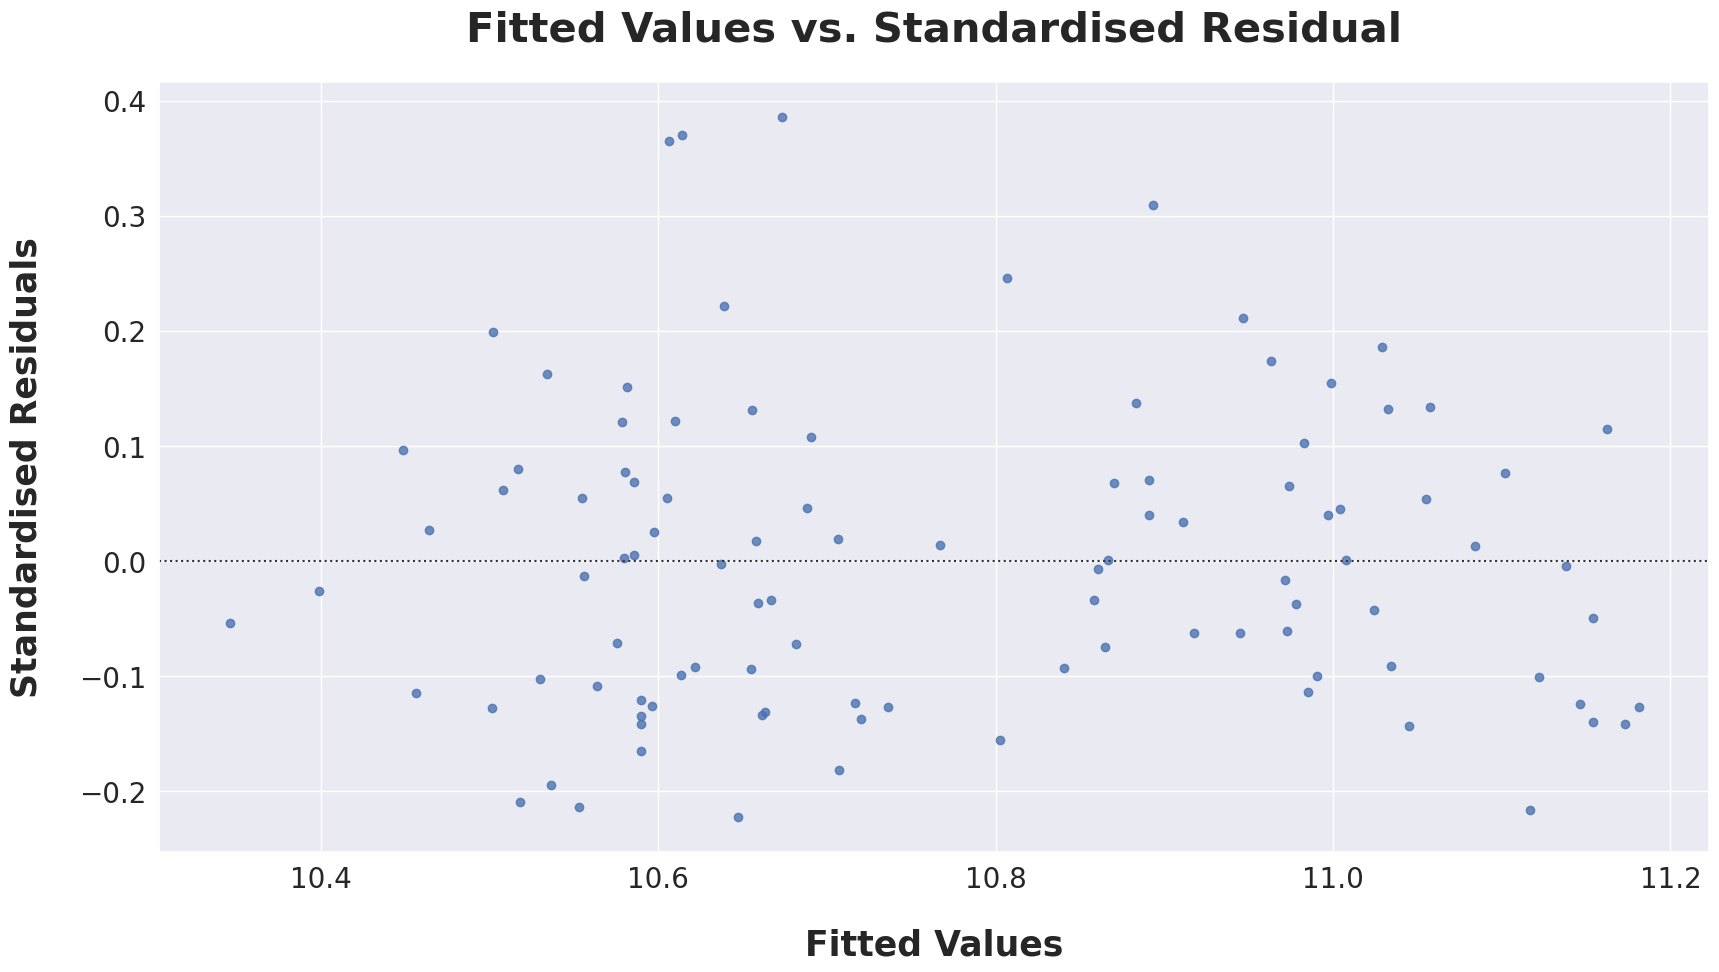

In [64]:
residuals = final_model.resid
fitted = final_model.fittedvalues

residuals_plot = sns.residplot(
    x=fitted,
    y=residuals
)

residuals_plot.set(title="Fitted Values vs. Standardised Residual")
residuals_plot.set(ylabel="Standardised Residuals")
residuals_plot.set(xlabel="Fitted Values")

plt.show()


<br />

<h4 align="center">Observation</h4>

<br />

<ul>
    <li>Though not perfectly so, there looks to be a homoscedastic relationship shown above</li>
    <br />
    <li>Secondly, no value goes beyond an exponentiate value of &#124; 3 &#124;, thus we can conclude that there are no concerns</li>
</ul>
<br />
<br />


<h2 align="center">Check for Multicollinearity in Final Model</h2>

<br />

<p>With the use of a <b><i>Variance Inflation Factor (VIF)</i></b> test, we can identify the correlation between independent variables and the strength of said correlation. That having been said, the fundamentals of <b><i>VIFs</i></b> are:</p>

<ul>
    <br />
    <li><b><i>VIFs</i></b> = 1 indicates that there is <b>no correlation</b></li>
    <br />
    <li>1 &lt; <b><i>VIFs</i></b> &lt; 5 suggests a <b>moderate correlation</b></li>
    <br />
    <li><b><i>VIFs</i></b> &gt; 5 shows a <b>strong correlation</b> and a quuestionable <b>p-value</b></li>
</ul>

<p>All cells have been centered via normalisation, as such, there is no structural collinearity.</p>

<p>Dummy variables were sorted as their reference columns were dropped in creating said dummies.</p>

<br />
<br />


<h4 align="center">Create Separate Experimental Data Frame</h4>

<br />
<br />


In [65]:
vif_df = X.copy()


<br />

<h4 align="center">Apply Variance Inflation Factor</h4>

<br />
<br />


In [66]:
vif_values = [
    variance_inflation_factor(vif_df.values, index)
    for index, _ in enumerate(vif_df.columns)
]


<br />

<h4 align="center">Outcome</h4>

<br />
<br />


In [67]:
pd.DataFrame(
    vif_values,
    index=vif_df.columns,
    columns=["VIF Values"]
).T


,years_in_field,executive_position,market_value,engineering_department
VIF Values,1.717352,1.955785,1.127218,1.361841


<br />

<h4 align="center">Observations regarding Multicollinearity</h4>

<br />

<ul>
    <li>No case that warrants change</li>
</ul>

<br />
<br />


<h2 align="center">Cross-Validation of Final Model</h2>

<br />
<br />


In [68]:
def cross_validate(X, y, k_fold):
    results = []

    for train_index, test_index in k_fold:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = sm.add_constant(X_train)
        X_test = sm.add_constant(X_test, has_constant="add")

        model = sm.OLS(y_train, X_train).fit()
        prediction = model.predict(X_test)

        if prediction.empty:
            break

        prediction = np.exp(prediction)
        y_test = np.exp(y_test)
        
        mae = eval_measures.meanabs(prediction, y_test)

        results.append(mae)

    return results


In [69]:
element_count = len(X.index)
k_fold = KFold(element_count, element_count - 1)

mean_absolute_errors = cross_validate(X, y, k_fold)

numerator = sum(mean_absolute_errors)
denominator = len(mean_absolute_errors)

numerator / denominator


5915.420860866846

<br />

<h4 align="center">Observation</h4>

<br />

<ul>
    <li>The sample mean of the Mean Absolute Score is higher than during the initial test run; this is a net negative, but still within 10% of the <b><i>Salary</i></b> range</li>
    <br />
    <li>Initial Mean Absolute Error Test: &dollar; 5 215.10</li>
    <br />
    <li>Sample Mean of Mean Absolute Error Test: &dollar; 5 915.42</li>
</ul>
<br />
<br />


<br />

<h2 align="center">Predicted vs. Provided</h2>
<h3 align="center">Visual Salary Comparison Using Test Split</h3>

<br />
<br />


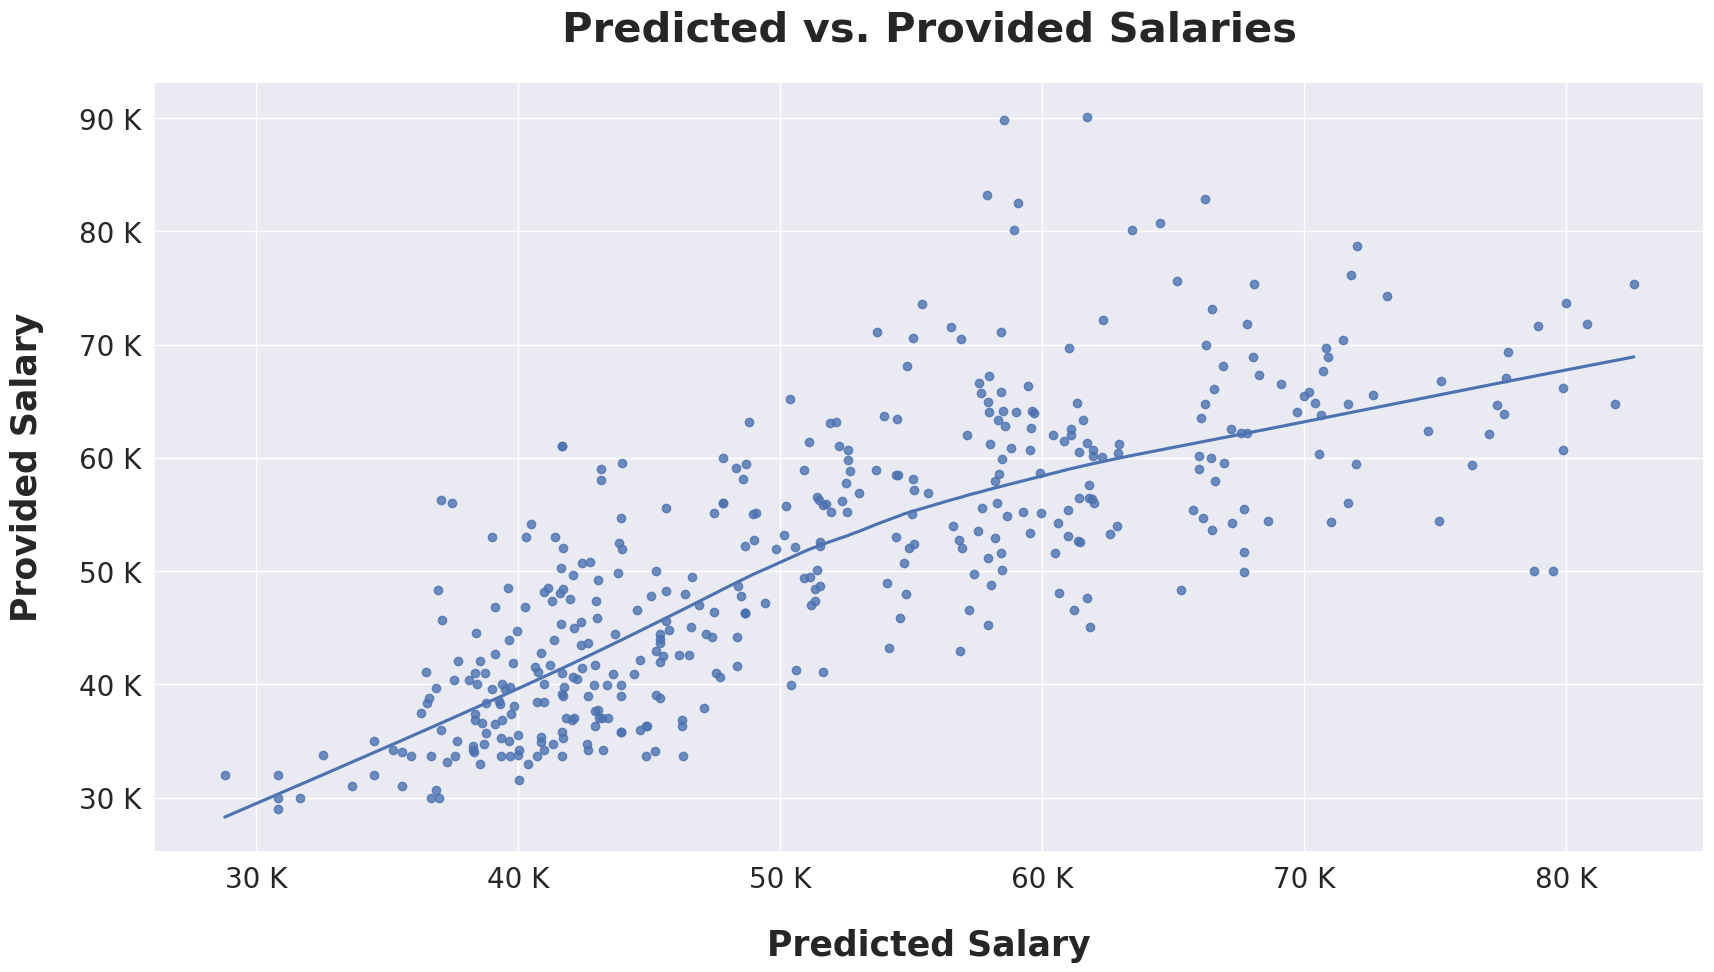

In [70]:
comparitive_graph = sns.regplot(
    x=predictions_test_dollars,
    y=y_test_dollars,
    lowess=True,
)

comparitive_graph.set(title="Predicted vs. Provided Salaries")
comparitive_graph.set(xlabel="Predicted Salary")
comparitive_graph.set(ylabel="Provided Salary")

tick_labels = [f"{num} K" for num in range(20, 91, 10)]

comparitive_graph.axes.set_yticklabels(tick_labels)
comparitive_graph.axes.set_xticklabels(tick_labels)

plt.show()


<br />

<h2 align="center">Conclusion</h2>

<br />
<br />

<ul>
    <li>There has been shown, there is a significant effect with p &lt; 0.01 and averaged collectively t(4) = 5.8760</li>
    <br />
    <li>An adjusted R<sup>2</sup> value of 0.72</li>
    <br />
    <li>There is a Mean Absolute Error value of:
        <ul>
            <li>Standardised: 0.1059</li>
            <li>In American Dollars: &dollar; 5215.10</li>
        </ul>
    </li>
    <br />
    <li>Furthermore the reduals look to be relatively homoscedastant</li>
    <br />
    <li>Finally, cross validation reveals the model to be within 10% of the <b><i>Salary</i></b> range</li>
</ul>

<br />
<br />
